# Part B: Predicting Specific New Product Purchases

## Goal

Having explored whether a user is *generally* likely to buy new products (Part A), the goal of Part B is to become more granular and **predict the probability that a specific user (`user_id`) will purchase a specific product (`product_id`) they have *never bought before*, in their next order.**

The ultimate application is to generate a **ranked list of personalized new product recommendations** for each user.

## How Part B Differs from Part A

*   **Focus:** User-Product interaction vs. User-level behavior.
*   **Target:** Probability for *each* potential (User, New Product) pair vs. Single probability for the user's overall order.
*   **Data Structure:** Requires rows representing (User, Product) pairs vs. Rows representing Users.
*   **Features:** Needs User features + **Product features** + **User-Product Interaction features** vs. Only User features.
*   **Output:** A ranked list of recommended *new* products vs. A single prediction about the user.

## High-Level Plan for Part B

We will follow a similar phased approach, but adapted for this user-product level task:

1.  **Phase B.1: Data Generation & Sampling:**
    *   Define positive examples: (User, New Product) pairs that *were* actually purchased in the 'train' order.
    *   Define negative candidates: (User, New Product) pairs that *were not* purchased in the 'train' order.
    *   Implement **negative sampling**: Select a manageable subset of the vast number of negative candidates to create a balanced or representative training dataset.
    *   Construct the final training table: `(user_id, product_id, target, ...features...)`.

2.  **Phase B.2: Feature Engineering (User, Product, Interaction):**
    *   **User Features:** Adapt/reuse aggregate user features from Part A.
    *   **Product Features:** Calculate features describing product characteristics (e.g., overall popularity, reorder rate, aisle/department info).
    *   **User-Product Interaction Features (CRITICAL):** Engineer features capturing the specific relationship between a user and a product (e.g., user's purchase frequency in the product's category, time since last purchase from aisle/dept, etc.).

3.  **Phase B.3: Model Training:**
    *   Train suitable models (e.g., XGBoost, LightGBM) on the generated user-product level data. These models need to learn from the combined user, product, and interaction features.

4.  **Phase B.4: Evaluation:**
    *   Evaluate model performance using standard metrics (AUC).
    *   Crucially, evaluate using **ranking metrics** (e.g., Precision@k, Recall@k, MAP) to assess how well the model ranks the truly purchased new products for each user.

5.  **Phase B.5: Deployment (Streamlit - Page 2 Conceptual):**
    *   Build the interactive "Personalized Recommender" page.
    *   Backend logic will involve: fetching user features, identifying candidate new products, fetching product features, calculating interaction features *on-the-fly* or via precomputation, getting model probabilities, ranking, and displaying results.

**Complexity Note:** Part B is significantly more complex than Part A, particularly regarding data generation/sampling and feature engineering for user-product interactions. Performance (both model accuracy and prediction speed) is also a key challenge.

# Part B - Phase B.1: Data Generation & Sampling

Our goal is to create a dataset where each row represents a potential purchase of a **specific product** by a **specific user** in their 'train' order, labeled with whether that purchase actually happened (target=1) or not (target=0). We only consider products the user had *never* bought before.

**Challenges:**
*   **Positive Examples:** Relatively few - only the new products actually bought in the 'train' orders.
*   **Negative Examples:** Huge number - for each user, there are ~50k products, most of which they didn't buy and hadn't bought before. We cannot use all of them.

**Approach:**
1.  **Identify Positive Examples:** Find all `(user_id, product_id)` pairs where the product was new for the user *and* appeared in their `orders.csv` 'train' order (via `order_products__train.csv`). Assign `target = 1`.
2.  **Identify Negative Candidates:** For each user, find all `product_id`s they have *never* purchased before (across *all* prior orders).
3.  **Filter Negative Candidates:** From the candidates in step 2, *exclude* any products that were actually purchased in the 'train' order (the positive examples).
4.  **Perform Negative Sampling:** From the remaining vast pool of negative candidates for each user, select a manageable number to include in the training data with `target = 0`. The ratio of negative to positive samples is crucial and affects model training. (e.g., 1:1, 5:1, 10:1 negatives to positives).
5.  **Combine:** Create the final DataFrame containing positive and sampled negative examples.

In [3]:
import pandas as pd
import numpy as np
import gc
import time
import os
from tqdm import tqdm # Optional: For progress bar

print("--- Phase B.1: Data Generation & Sampling (User-by-User) ---")
start_time = time.time()

# --- Load Required Base DataFrames ---
print("Loading base datasets...")
data_path = 'data'
# (Use the same dtype definitions as before)
orders_dtypes = {'order_id': 'int32', 'user_id': 'int32', 'order_number': 'int16', 'order_dow': 'int8', 'order_hour_of_day': 'int8', 'days_since_prior_order': 'float32', 'eval_set': 'category'}
products_dtypes = {'product_id': 'int32', 'aisle_id': 'int16', 'department_id': 'int8', 'product_name': 'object'}
order_products_dtypes = {'order_id': 'int32', 'product_id': 'int32', 'add_to_cart_order': 'int16', 'reordered': 'int8'}

try:
    orders_df = pd.read_csv(os.path.join(data_path, 'orders.csv'), dtype=orders_dtypes)
    products_df = pd.read_csv(os.path.join(data_path, 'products.csv'), dtype=products_dtypes)
    order_products_prior_df = pd.read_csv(os.path.join(data_path, 'order_products__prior.csv'), dtype=order_products_dtypes)
    order_products_train_df = pd.read_csv(os.path.join(data_path, 'order_products__train.csv'), dtype=order_products_dtypes)
    print("Base datasets loaded successfully.")
except FileNotFoundError as e:
     raise FileNotFoundError(f"ERROR: Could not load base data file. Ensure CSVs are in '{data_path}'. Original error: {e}")

# --- Pre-prepare some data structures ---

# 1. Identify Positive Examples (User bought NEW product in train order) - Same as before
train_orders = orders_df[orders_df['eval_set'] == 'train'][['user_id', 'order_id']].copy()
target_user_ids = train_orders['user_id'].unique()
train_order_contents = train_orders.merge(order_products_train_df[['order_id', 'product_id', 'reordered']], on='order_id', how='inner')
positive_examples_df = train_order_contents[train_order_contents['reordered'] == 0][['user_id', 'product_id']].copy()
positive_examples_df['target'] = 1
print(f"Identified {len(positive_examples_df)} positive examples.")
# Create a set of positive (user, product) tuples for fast lookups later
positive_user_prod_set = set(zip(positive_examples_df['user_id'], positive_examples_df['product_id']))
# Create a lookup for number of positives per user
positive_counts = positive_examples_df.groupby('user_id').size()
del train_order_contents # Free memory
gc.collect()


# 2. Get all unique products
all_product_ids = set(products_df['product_id'].unique())
print(f"Total unique products: {len(all_product_ids)}")

# 3. Pre-aggregate PRIOR purchases for ALL users (might still be large, but done once)
print("Pre-aggregating prior purchases per user...")
prior_order_ids = orders_df[orders_df['eval_set'] == 'prior']['order_id']
user_product_prior_pairs = order_products_prior_df[order_products_prior_df['order_id'].isin(prior_order_ids)][['order_id', 'product_id']].copy()
del prior_order_ids
del order_products_prior_df # Free memory
gc.collect()
user_product_prior_pairs = user_product_prior_pairs.merge(orders_df[['order_id', 'user_id']], on='order_id', how='left')
# Create a dictionary mapping user_id to the set of products they bought prior
user_to_prior_products = user_product_prior_pairs.groupby('user_id')['product_id'].apply(set).to_dict()
print("Created lookup for user's prior purchased products.")
del user_product_prior_pairs # Free memory
gc.collect()

# --- Process User by User ---
print("Processing users individually to generate training samples...")
all_user_samples = [] # List to store DataFrames for each user
negative_sampling_ratio = 5 # Keep ratio low for testing

# Use tqdm for a progress bar (optional, install if needed: pip install tqdm)
for user_id in tqdm(target_user_ids, desc="Processing Users"):
#for user_id in target_user_ids: # Loop without progress bar

    # a. Get products this user bought prior
    prior_products = user_to_prior_products.get(user_id, set())

    # b. Identify products never purchased by this user
    never_purchased_by_user = all_product_ids - prior_products

    # c. Filter out positive examples for this user
    # Find products that are in never_purchased AND NOT positive examples for this user
    negative_candidates_for_user = set()
    for product_id in never_purchased_by_user:
        if (user_id, product_id) not in positive_user_prod_set:
            negative_candidates_for_user.add(product_id)

    # d. Sample negatives for this user
    n_positive = positive_counts.get(user_id, 0)
    n_to_sample = n_positive * negative_sampling_ratio
    n_available = len(negative_candidates_for_user)
    n_to_sample = min(n_to_sample, n_available) # Don't sample more than available

    sampled_negatives_prods = set()
    if n_to_sample > 0:
        # np.random.choice is faster for sampling from sets/lists than pd.sample
        sampled_negatives_prods = set(np.random.choice(list(negative_candidates_for_user), size=int(n_to_sample), replace=False))

    # e. Create rows for this user
    user_positives = positive_examples_df[positive_examples_df['user_id'] == user_id]
    user_negatives = pd.DataFrame({
        'user_id': user_id,
        'product_id': list(sampled_negatives_prods),
        'target': 0
    })

    # f. Append to list
    all_user_samples.append(user_positives)
    all_user_samples.append(user_negatives)

    # Optional: Periodic GC to manage memory during loop
    # if user_id % 1000 == 0:
    #     gc.collect()

# --- Combine results for all users ---
print("Combining samples from all users...")
final_training_data_part_b = pd.concat(all_user_samples, ignore_index=True)

# Shuffle the final dataset
final_training_data_part_b = final_training_data_part_b.sample(frac=1, random_state=42).reset_index(drop=True)

end_time = time.time()
print(f"\nPhase B.1 Data Generation Complete (User-by-User). Time taken: {end_time - start_time:.2f} seconds.")
print("\nFinal Training Data (`final_training_data_part_b`) Head:")
print(final_training_data_part_b.head())
print(f"\nFinal Training Data Shape: {final_training_data_part_b.shape}")
print("\nFinal Training Data Target Distribution:")
print(final_training_data_part_b['target'].value_counts(normalize=True))
print("-" * 50)

# Save this intermediate result
save_path_b1 = os.path.join(data_path, 'partB_training_candidates_user_by_user.csv') # New name
print(f"Saving intermediate training data structure to {save_path_b1}...")
final_training_data_part_b.to_csv(save_path_b1, index=False)
print("Intermediate data saved.")

# Clean up final large DFs from memory if needed
# del final_training_data_part_b
# del user_to_prior_products
# gc.collect()

--- Phase B.1: Data Generation & Sampling (User-by-User) ---
Loading base datasets...
Base datasets loaded successfully.
Identified 555793 positive examples.
Total unique products: 49688
Pre-aggregating prior purchases per user...
Created lookup for user's prior purchased products.
Processing users individually to generate training samples...


Processing Users: 100%|██████████| 131209/131209 [30:04<00:00, 72.69it/s] 


Combining samples from all users...

Phase B.1 Data Generation Complete (User-by-User). Time taken: 1831.54 seconds.

Final Training Data (`final_training_data_part_b`) Head:
   user_id  product_id  target
0   145241      6801.0       0
1   171231     33616.0       0
2   104900     39993.0       1
3   179805     18015.0       0
4   133084     28366.0       0

Final Training Data Shape: (3334758, 3)

Final Training Data Target Distribution:
target
0    0.833333
1    0.166667
Name: proportion, dtype: float64
--------------------------------------------------
Saving intermediate training data structure to data/partB_training_candidates_user_by_user.csv...
Intermediate data saved.


# Part B - Phase B.2: Feature Engineering (User, Product, Interaction)

In Phase B.1, we created our training data structure: `(user_id, product_id, target)`. The target indicates if the user bought that specific *new* product in their 'train' order.

Now, we need to add features to this dataset. Our model needs information about the user, the product, and their specific interaction to predict the target effectively.

**Feature Categories:**

1.  **User Features:** General purchasing habits (similar to Part A, but calculated for *all* relevant users).
    *   Examples: `u_total_orders`, `u_avg_days_since_prior`, `u_avg_basket_size`, `u_reorder_ratio`, `u_total_items`, etc.
2.  **Product Features:** Characteristics of the product itself based on overall purchasing data.
    *   Examples: `p_purchase_count` (popularity), `p_reorder_rate`, `p_avg_add_to_cart_order`, aisle/department info.
3.  **User-Product Interaction Features:** Features capturing the specific historical relationship.
    *   Examples: `uxp_times_bought_before` (should be 0 for this task as we only predict for new products, but useful conceptually), `uxp_reorder_rate_in_user_orders`, `uxp_days_since_last_bought_aisle/dept`, `uxp_order_streak_for_product`.

**Process:**
1. Calculate User features for all relevant users.
2. Calculate Product features for all products.
3. Merge User and Product features onto our `(user_id, product_id, target)` dataset.
4. Engineer and merge User-Product Interaction features (starting simple).
5. Save the final feature-rich training dataset.

In [23]:
import pandas as pd
import numpy as np
import gc
import time
import os

print("--- Phase B.2: Feature Engineering ---")
start_time = time.time()

# --- Load Base Data & Intermediate Training Structure ---
print("Loading base datasets and intermediate training data...")
data_path = 'data'
# Load base data again if kernel restarted or needed
orders_dtypes = {'order_id': 'int32', 'user_id': 'int32', 'order_number': 'int16', 'order_dow': 'int8', 'order_hour_of_day': 'int8', 'days_since_prior_order': 'float32', 'eval_set': 'category'}
products_dtypes = {'product_id': 'int32', 'aisle_id': 'int16', 'department_id': 'int8', 'product_name': 'object'}
order_products_dtypes = {'order_id': 'int32', 'product_id': 'int32', 'add_to_cart_order': 'int16', 'reordered': 'int8'}
aisles_dtypes = {'aisle_id': 'int16', 'aisle': 'object'}
departments_dtypes = {'department_id': 'int8', 'department': 'object'}

try:
    orders_df = pd.read_csv(os.path.join(data_path, 'orders.csv'), dtype=orders_dtypes)
    products_df = pd.read_csv(os.path.join(data_path, 'products.csv'), dtype=products_dtypes)
    # IMPORTANT: Need order_products_prior for feature calculation
    order_products_prior_df = pd.read_csv(os.path.join(data_path, 'order_products__prior.csv'), dtype=order_products_dtypes)
    aisles_df = pd.read_csv(os.path.join(data_path, 'aisles.csv'), dtype=aisles_dtypes)
    departments_df = pd.read_csv(os.path.join(data_path, 'departments.csv'), dtype=departments_dtypes)

    # Load the output from Phase B.1
    train_cand_path = os.path.join(data_path, 'partB_training_candidates_user_by_user.csv')
    df_train = pd.read_csv(train_cand_path)
    print("Base data and training candidates loaded.")
except FileNotFoundError as e:
     raise FileNotFoundError(f"ERROR: Could not load base data or training candidates file. Ensure '{train_cand_path}' exists. Original error: {e}")

# Merge product category info early - needed for many features
products_full_df = products_df.merge(aisles_df, on='aisle_id').merge(departments_df, on='department_id')
del aisles_df
del departments_df
gc.collect()

# --- 1. Calculate User Features ---
# We can reuse logic from Part A, but calculate for ALL users with prior orders
# This can be slow, consider saving/loading if run often
print("Calculating User Features...")

# Merge orders with prior products to get items per order etc.
orders_w_products = orders_df[orders_df['eval_set'] == 'prior'].merge(
                        order_products_prior_df[['order_id', 'product_id', 'reordered']],
                        on='order_id', how='inner')

# Calculate basic user stats (similar to Part A, but maybe broader user set if needed)
user_features = orders_df[orders_df['eval_set'] == 'prior'].groupby('user_id').agg(
    u_total_orders=('order_number', 'max'),
    u_avg_days_since_prior=('days_since_prior_order', 'mean'),
    u_std_days_since_prior=('days_since_prior_order', 'std'),
    u_median_days_since_prior=('days_since_prior_order', 'median'),
).reset_index()
user_features['u_std_days_since_prior'].fillna(0, inplace=True)
user_features['u_avg_days_since_prior'].fillna(0, inplace=True)
user_features['u_median_days_since_prior'].fillna(0, inplace=True)


# Calculate basket & reorder stats
user_prod_agg = orders_w_products.groupby('user_id').agg(
    u_total_items_purchased=('product_id', 'count'),
    u_reorder_sum=('reordered', 'sum')
).reset_index()
user_prod_agg['u_reorder_ratio'] = (user_prod_agg['u_reorder_sum'] / user_prod_agg['u_total_items_purchased']).fillna(0)

# Avg basket size
basket_sizes = orders_w_products.groupby(['user_id', 'order_id'])['product_id'].count().reset_index(name='basket_size')
avg_basket_size = basket_sizes.groupby('user_id')['basket_size'].mean().reset_index()
avg_basket_size.rename(columns={'basket_size': 'u_avg_basket_size'}, inplace=True)

# Merge user features together
user_features = user_features.merge(user_prod_agg, on='user_id', how='left')
user_features = user_features.merge(avg_basket_size, on='user_id', how='left')
user_features.fillna(0, inplace=True) # Fill NaNs for users potentially missed in merges

print(f"Calculated {len(user_features.columns)-1} user features for {len(user_features)} users.")
# Optional: Save user_features to CSV for faster loading next time
# user_features.to_csv(os.path.join(data_path, 'partB_user_features.csv'), index=False)

del orders_w_products
del user_prod_agg
del avg_basket_size
del basket_sizes
gc.collect()

# --- 2. Calculate Product Features ---
print("Calculating Product Features...")

# Get prior orders only
prior_orders_products = orders_df[orders_df['eval_set'] == 'prior'][['order_id']].merge(
                           order_products_prior_df, on='order_id', how='inner')

# Calculate product stats
product_features = prior_orders_products.groupby('product_id').agg(
    p_purchase_count=('order_id', 'count'), # How many times was product bought
    p_reorder_sum=('reordered', 'sum'),     # How many times was it a reorder
    p_avg_add_to_cart=('add_to_cart_order', 'mean')
).reset_index()
product_features['p_reorder_rate'] = (product_features['p_reorder_sum'] / product_features['p_purchase_count']).fillna(0)

# Merge with product category info
product_features = product_features.merge(products_full_df[['product_id', 'aisle_id', 'department_id']], on='product_id', how='left')

print(f"Calculated {len(product_features.columns)-1} product features for {len(product_features)} products.")
# Optional: Save product_features to CSV
# product_features.to_csv(os.path.join(data_path, 'partB_product_features.csv'), index=False)

del prior_orders_products
gc.collect()


# --- 3. Merge User & Product Features onto Training Data ---
print("Merging features into training data...")
# df_train has user_id, product_id, target
df_train = df_train.merge(user_features, on='user_id', how='left')
df_train = df_train.merge(product_features, on='product_id', how='left')

# Fill NaNs that might appear if a user/product in df_train somehow wasn't in the feature calculations
# (Shouldn't happen with inner merges during feature calc, but good practice)
df_train.fillna(0, inplace=True) # Simple fill with 0 for now, might need smarter fill later

print(f"Training data shape after merging User/Product features: {df_train.shape}")


# --- 4. Engineer User-Product Interaction Features (Example: User history with Product's Department) ---
print("Calculating example User-Product Interaction features...")

# How many times has this user bought *any* product from *this specific product's* department?
# Need user_id, department_id, count
# First, get department_id into the prior order contents
orders_w_products_dept = orders_df[orders_df['eval_set'] == 'prior'].merge(
                            order_products_prior_df[['order_id', 'product_id']], on='order_id', how='inner')
orders_w_products_dept = orders_w_products_dept.merge(
                            products_full_df[['product_id', 'department_id']], on='product_id', how='left')

user_dept_purchase_counts = orders_w_products_dept.groupby(['user_id', 'department_id']).size().reset_index(name='uxp_dept_purchase_count')

# Merge this onto the training data based on user_id and the product's department_id
df_train = df_train.merge(
    user_dept_purchase_counts,
    on=['user_id', 'department_id'], # Merge based on user and the CURRENT product's department
    how='left'
)
df_train['uxp_dept_purchase_count'].fillna(0, inplace=True) # If user never bought from this dept, count is 0

print("Added user-department purchase count.")
del orders_w_products_dept
del user_dept_purchase_counts
gc.collect()

# --- TODO: Add more interaction features! ---
# Examples:
# - User's reorder rate *within this product's department/aisle*
# - Time since user last purchased from this product's department/aisle
# - Number of times user bought this product (should be 0 here) vs avg position added to cart
# - etc... (This is where domain knowledge and creativity come in)

# --- 5. Save Final Feature-Rich Dataset ---
print("Final feature engineering stage complete.")
final_save_path_b2 = os.path.join(data_path, 'partB_training_data_with_features.csv') # New name
print(f"Saving final training data with features to {final_save_path_b2}...")
# Optional: Select subset of columns if some intermediate ones aren't needed
df_train.to_csv(final_save_path_b2, index=False)
print("Final data saved.")

end_time = time.time()
print(f"\nPhase B.2 Feature Engineering Complete. Time taken: {end_time - start_time:.2f} seconds.")
print("\nFinal Training Data (`df_train`) Head:")
print(df_train.head())
print(f"\nFinal Training Data Shape: {df_train.shape}")
print("\nColumns in final training data:")
print(df_train.columns.tolist())
print("-" * 50)

# --- Add/Uncomment these lines within the appropriate cell in PartB.ipynb ---

# After user_features is created:
user_features_save_path = os.path.join(data_path, 'partB_user_features.csv')
print(f"Saving user features to {user_features_save_path}...")
user_features.to_csv(user_features_save_path, index=False)
print("User features saved.")

# After product_features is created:
product_features_save_path = os.path.join(data_path, 'partB_product_features.csv')
print(f"Saving product features to {product_features_save_path}...")
product_features.to_csv(product_features_save_path, index=False)
print("Product features saved.")

--- Phase B.2: Feature Engineering ---
Loading base datasets and intermediate training data...
Base data and training candidates loaded.
Calculating User Features...


/var/folders/51/pys4jc71057cwt5cvjb3qqh80000gn/T/ipykernel_92760/1803326120.py:58: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  user_features['u_std_days_since_prior'].fillna(0, inplace=True)
/var/folders/51/pys4jc71057cwt5cvjb3qqh80000gn/T/ipykernel_92760/1803326120.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are se

Calculated 8 user features for 206209 users.
Calculating Product Features...
Calculated 6 product features for 49677 products.
Merging features into training data...
Training data shape after merging User/Product features: (3334758, 17)
Calculating example User-Product Interaction features...


/var/folders/51/pys4jc71057cwt5cvjb3qqh80000gn/T/ipykernel_92760/1803326120.py:148: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['uxp_dept_purchase_count'].fillna(0, inplace=True) # If user never bought from this dept, count is 0


Added user-department purchase count.
Final feature engineering stage complete.
Saving final training data with features to data/partB_training_data_with_features.csv...
Final data saved.

Phase B.2 Feature Engineering Complete. Time taken: 74.58 seconds.

Final Training Data (`df_train`) Head:
   user_id  product_id  target  u_total_orders  u_avg_days_since_prior  \
0   145241      6801.0       0               3               30.000000   
1   171231     33616.0       0               4               12.666667   
2   104900     39993.0       1               3               30.000000   
3   179805     18015.0       0               4               24.666666   
4   133084     28366.0       0               5               18.000000   

   u_std_days_since_prior  u_median_days_since_prior  u_total_items_purchased  \
0                0.000000                       30.0                       28   
1                9.865766                        8.0                       88   
2               

# Part B - Phase B.3: Model Training

We have prepared our training dataset (`df_train`) containing `user_id`, `product_id`, `target`, and a set of User, Product, and basic Interaction features.

Now, we will train a model to predict the `target` variable (whether a user bought a specific new product).

**Model Choice: LightGBM**
Given the potentially large size and high imbalance of this dataset, we will use **LightGBM (Light Gradient Boosting Machine)**.
*   **Why LightGBM?** It's another powerful gradient boosting algorithm like XGBoost, but it's known for being significantly **faster** and often more **memory-efficient**, especially on large datasets. It uses techniques like Gradient-based One-Side Sampling (GOSS) and Exclusive Feature Bundling (EFB). It also handles categorical features well (though we don't have many explicit ones yet) and includes parameters for handling imbalance.

**Process:**
1. Define features (X) and target (y) from our prepared dataset.
2. Split the data into stratified training and testing sets.
3. Initialize and train a LightGBM Classifier, ensuring we account for class imbalance.

In [8]:
import pandas as pd
import numpy as np
import lightgbm as lgb # Import LightGBM
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix # Add metrics needed
import gc
import time
import os
import matplotlib.pyplot as plt # Add plotting imports
import seaborn as sns

print("--- Phase B.3: Model Training (LightGBM) ---")
start_time = time.time()

# --- Load Feature-Rich Data ---
data_path = 'data'
train_data_path = os.path.join(data_path, 'partB_training_data_with_features.csv')
try:
    df_train_features = pd.read_csv(train_data_path)
    print(f"Loaded training data with features. Shape: {df_train_features.shape}")
except FileNotFoundError:
     raise FileNotFoundError(f"ERROR: Training data file not found at {train_data_path}. Rerun Phase B.2.")

# --- 1. Define Features (X) and Target (y) ---
# Define columns to drop (identifiers, target, maybe intermediate IDs)
cols_to_drop = ['user_id', 'product_id', 'target', 'aisle_id', 'department_id']
# Ensure columns actually exist before dropping
cols_to_drop = [col for col in cols_to_drop if col in df_train_features.columns]

X_partB = df_train_features.drop(columns=cols_to_drop)
y_partB = df_train_features['target']
feature_names_partB = X_partB.columns.tolist() # Get feature names

print(f"Features (X_partB) shape: {X_partB.shape}")
print(f"Target (y_partB) shape: {y_partB.shape}")
print(f"Features used: {feature_names_partB}")


# --- 2. Train-Test Split (Stratified) ---
print("Splitting data into train and test sets...")
test_set_size_B = 0.20
reproducible_state_B = 42

X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(
    X_partB,
    y_partB,
    test_size=test_set_size_B,
    random_state=reproducible_state_B,
    stratify=y_partB # Very important due to high imbalance
)
print(f"X_train_B shape: {X_train_B.shape}")
print(f"X_test_B shape: {X_test_B.shape}")
print("Target distribution in y_train_B:")
print(y_train_B.value_counts(normalize=True))
print("Target distribution in y_test_B:")
print(y_test_B.value_counts(normalize=True))


# --- 3. Initialize and Train LightGBM Model ---
print("\nInitializing and training LightGBM Classifier...")

# Handle Imbalance: Calculate scale_pos_weight or use is_unbalance=True
count_neg_B = y_train_B.value_counts()[0]
count_pos_B = y_train_B.value_counts()[1]
scale_pos_weight_B = count_neg_B / count_pos_B if count_pos_B > 0 else 1
print(f"Calculated scale_pos_weight for LightGBM: {scale_pos_weight_B:.2f}")

lgb_params = {
    'objective': 'binary', # Binary classification
    'metric': 'auc',       # Optimize for AUC metric during training
    'boosting_type': 'gbdt',
    'n_estimators': 1000,  # Start with a decent number, can tune later
    'learning_rate': 0.05, # Common starting learning rate
    'num_leaves': 31,      # Default, controls tree complexity
    'max_depth': -1,       # Default (no limit), can tune
    'seed': 42,
    'n_jobs': -1,
    'verbose': -1,         # Suppress verbose training output
    # Option 1: Use scale_pos_weight (like XGBoost)
    'scale_pos_weight': scale_pos_weight_B
    # Option 2: Use is_unbalance=True (LGBM specific flag)
    # 'is_unbalance': True
}

lgbm_model = lgb.LGBMClassifier(**lgb_params)

# Train with early stopping (optional but recommended)
# Requires a validation set separate from the test set
# For simplicity now, we train on the full X_train_B
print("Training LightGBM model...")
lgbm_model.fit(X_train_B, y_train_B)
print("Model training complete.")

# --- Phase B.3 Complete ---
# Evaluation will be in Phase B.4
model_train_end_time = time.time()
print(f"\nPhase B.3 Model Training Complete. Time taken: {model_train_end_time - start_time:.2f} seconds.")
print("-" * 50)

# Save the trained model
model_save_path_b3 = os.path.join('models', 'partB_lgbm_model.txt') # LGBM often saved as txt
print(f"Saving trained LightGBM model to {model_save_path_b3}...")
os.makedirs('models', exist_ok=True)
lgbm_model.booster_.save_model(model_save_path_b3) # Use internal booster API
print("Model saved.")

--- Phase B.3: Model Training (LightGBM) ---
Loaded training data with features. Shape: (3334758, 18)
Features (X_partB) shape: (3334758, 13)
Target (y_partB) shape: (3334758,)
Features used: ['u_total_orders', 'u_avg_days_since_prior', 'u_std_days_since_prior', 'u_median_days_since_prior', 'u_total_items_purchased', 'u_reorder_sum', 'u_reorder_ratio', 'u_avg_basket_size', 'p_purchase_count', 'p_reorder_sum', 'p_avg_add_to_cart', 'p_reorder_rate', 'uxp_dept_purchase_count']
Splitting data into train and test sets...
X_train_B shape: (2667806, 13)
X_test_B shape: (666952, 13)
Target distribution in y_train_B:
target
0    0.833333
1    0.166667
Name: proportion, dtype: float64
Target distribution in y_test_B:
target
0    0.833333
1    0.166667
Name: proportion, dtype: float64

Initializing and training LightGBM Classifier...
Calculated scale_pos_weight for LightGBM: 5.00
Training LightGBM model...
Model training complete.

Phase B.3 Model Training Complete. Time taken: 30.80 seconds.
---

# Part B - Phase B.4: Evaluation

Now that we have trained our LightGBM model (`lgbm_model`) on the user-product level data, we need to evaluate its performance on the held-out test set (`X_test_B`, `y_test_B`).

**Evaluation Metrics:**

1.  **AUC-ROC:** As before, this measures the model's overall ability to distinguish between positive (target=1) and negative (target=0) user-product pairs. Higher is better (1.0 is perfect, 0.5 is random).
2.  **Classification Report / Confusion Matrix:** We can still look at these using a standard 0.5 threshold (or another chosen threshold) to understand precision/recall for predicting if *any* specific sampled pair is positive or negative. However, due to the extreme imbalance and sampling, these might be less informative than ranking metrics.
3.  **Precision@k:** This is a crucial **ranking metric** for recommendation tasks. It answers: "If we look at the top *k* products recommended by the model for a user (those with the highest predicted probability), what proportion of those *k* products did the user actually buy?"
    *   We need to calculate this *per user* and then average it.
    *   Requires predicting probabilities for *all* relevant new products for test users, not just the sampled ones used for training/testing the classifier itself. This makes direct calculation complex within this evaluation framework.

**Simplified Evaluation Approach for Now:**
For this iteration, we will focus on:
*   **AUC-ROC** on the test set (`X_test_B`, `y_test_B`) as a measure of overall ranking ability.
*   **Classification Report** using the default 0.5 threshold to get a basic sense of classification performance on the sampled data, keeping the high imbalance in mind.

Calculating true Precision@k would require generating predictions for a much larger set of candidate products per user, which is beyond the scope of this initial modeling step.

--- Phase B.4: Evaluation (LightGBM) ---
Loaded trained LightGBM model.


NameError: ERROR: Test data (X_test_B, y_test_B) not found. Rerun Phase B.3 split.

--- Phase B.4: Evaluation (LightGBM) ---
Loaded trained LightGBM model.

DEBUG: Checking if test variables exist...
DEBUG: X_test_B found, shape: (666952, 13)
DEBUG: y_test_B found, shape: (666952,)
DEBUG: Test variables seem to exist.
Generating predictions on the test set...
Predictions generated.

--- LightGBM Part B Evaluation Metrics ---
AUC-ROC:   0.9166

Classification Report (Threshold = 0.5):
                  precision    recall  f1-score   support

Class 0 (No Buy)       0.96      0.84      0.90    555793
   Class 1 (Buy)       0.51      0.84      0.64    111159

        accuracy                           0.84    666952
       macro avg       0.74      0.84      0.77    666952
    weighted avg       0.89      0.84      0.85    666952


Metrics at Threshold 0.5:
Accuracy:  0.8398
Precision (Class 1): 0.5118
Recall (Class 1):    0.8381
F1-Score (Class 1):  0.6355

Confusion Matrix (Threshold = 0.5):


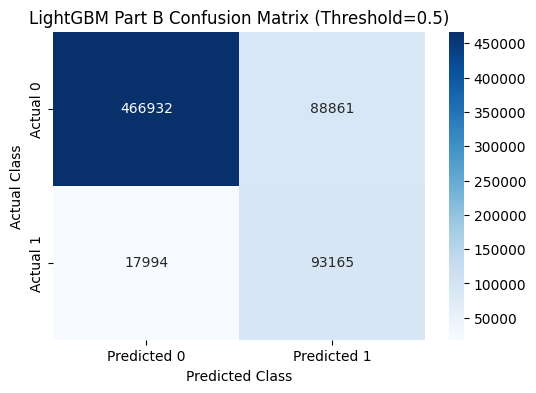


LightGBM Feature Importances:
                      Feature    Importance
8            p_purchase_count  2.582828e+07
11             p_reorder_rate  6.853802e+05
12    uxp_dept_purchase_count  6.039205e+05
10          p_avg_add_to_cart  2.905094e+05
7           u_avg_basket_size  2.126673e+05
6             u_reorder_ratio  1.459260e+05
4     u_total_items_purchased  9.928944e+04
5               u_reorder_sum  8.482990e+04
2      u_std_days_since_prior  7.721856e+04
1      u_avg_days_since_prior  7.530992e+04
9               p_reorder_sum  4.803301e+04
0              u_total_orders  3.805378e+04
3   u_median_days_since_prior  3.734746e+04


/var/folders/51/pys4jc71057cwt5cvjb3qqh80000gn/T/ipykernel_92760/1638754512.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_lgbm_df, palette='viridis')


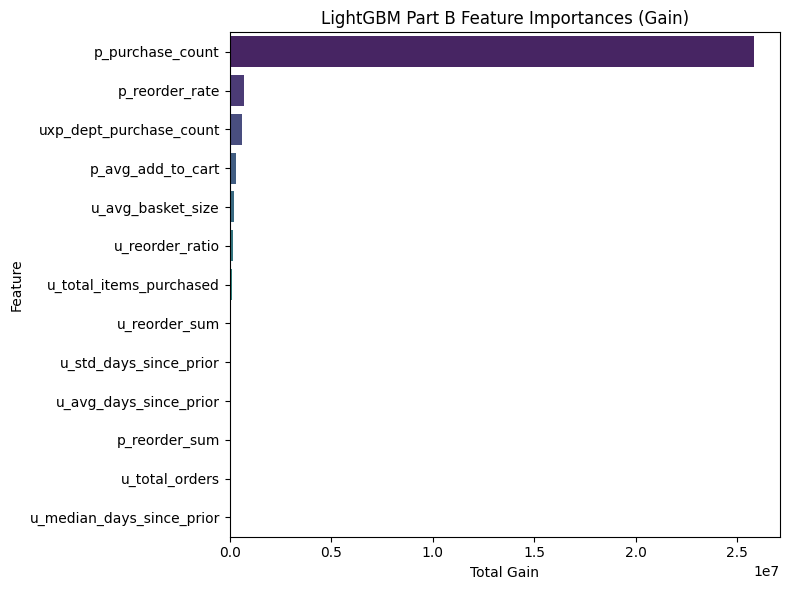


Phase B.4 Evaluation Complete. Time taken: 3.67 seconds.
--------------------------------------------------


In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

print("--- Phase B.4: Evaluation (LightGBM) ---")
start_time = time.time()

# --- Load Trained Model ---
model_path = os.path.join('models', 'partB_lgbm_model.txt')
try:
    bst = lgb.Booster(model_file=model_path)
    print("Loaded trained LightGBM model.")
except Exception as e:
     raise FileNotFoundError(f"ERROR: Could not load model from {model_path}. Ensure it was saved correctly. Original error: {e}")

# --- Explicitly Check Variables BEFORE the check that failed ---
print("\nDEBUG: Checking if test variables exist...")
variables_exist = True
if 'X_test_B' not in locals():
    print("DEBUG: X_test_B is MISSING!")
    variables_exist = False
else:
    print(f"DEBUG: X_test_B found, shape: {X_test_B.shape if isinstance(X_test_B, pd.DataFrame) else type(X_test_B)}")

if 'y_test_B' not in locals():
    print("DEBUG: y_test_B is MISSING!")
    variables_exist = False
else:
    print(f"DEBUG: y_test_B found, shape: {y_test_B.shape if isinstance(y_test_B, pd.Series) else type(y_test_B)}")

if not variables_exist:
    raise NameError("Stopping execution because test data variables were not found.")
else:
    print("DEBUG: Test variables seem to exist.")

# --- Make Predictions on Test Set ---
print("Generating predictions on the test set...")
# Predict probabilities for the positive class (1)
# Use the booster directly for prediction
y_pred_proba_lgbm_B = bst.predict(X_test_B)
# Predict class labels using default 0.5 threshold
y_pred_lgbm_B = (y_pred_proba_lgbm_B >= 0.5).astype(int)
print("Predictions generated.")

# --- Evaluate Performance ---
print("\n--- LightGBM Part B Evaluation Metrics ---")

# 1. AUC-ROC
roc_auc_lgbm_B = roc_auc_score(y_test_B, y_pred_proba_lgbm_B)
print(f"AUC-ROC:   {roc_auc_lgbm_B:.4f}")

# 2. Classification Report (at default 0.5 threshold)
print("\nClassification Report (Threshold = 0.5):")
# Note: Interpretation requires considering the ~1:5 imbalance in the test set
print(classification_report(y_test_B, y_pred_lgbm_B, target_names=['Class 0 (No Buy)', 'Class 1 (Buy)']))

# Calculate other metrics at 0.5 threshold for context
accuracy_lgbm_B = accuracy_score(y_test_B, y_pred_lgbm_B)
precision_lgbm_B = precision_score(y_test_B, y_pred_lgbm_B) # Class 1
recall_lgbm_B = recall_score(y_test_B, y_pred_lgbm_B)       # Class 1
f1_lgbm_B = f1_score(y_test_B, y_pred_lgbm_B)               # Class 1
print(f"\nMetrics at Threshold 0.5:")
print(f"Accuracy:  {accuracy_lgbm_B:.4f}")
print(f"Precision (Class 1): {precision_lgbm_B:.4f}")
print(f"Recall (Class 1):    {recall_lgbm_B:.4f}")
print(f"F1-Score (Class 1):  {f1_lgbm_B:.4f}")


# 3. Confusion Matrix (at default 0.5 threshold)
print("\nConfusion Matrix (Threshold = 0.5):")
cm_lgbm_B = confusion_matrix(y_test_B, y_pred_lgbm_B)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lgbm_B, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('LightGBM Part B Confusion Matrix (Threshold=0.5)')
# Ensure images directory exists
if not os.path.exists('images'):
    os.makedirs('images')
plt.savefig('images/partB_lgbm_cm_05.png', bbox_inches='tight')
plt.show()

# 4. Feature Importance (from LightGBM)
print("\nLightGBM Feature Importances:")
feature_importance_lgbm_B = bst.feature_importance(importance_type='gain') # 'gain' often preferred over 'split'
feature_importance_lgbm_df = pd.DataFrame({
    'Feature': X_test_B.columns.tolist(), # Get names from test set features
    'Importance': feature_importance_lgbm_B
}).sort_values(by='Importance', ascending=False)
print(feature_importance_lgbm_df)

# Plot feature importances
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_lgbm_df, palette='viridis')
plt.title('LightGBM Part B Feature Importances (Gain)')
plt.xlabel('Total Gain')
plt.ylabel('Feature')
plt.tight_layout()
# Ensure images directory exists
if not os.path.exists('images'):
    os.makedirs('images')
plt.savefig('images/partB_lgbm_feat_imp.png', bbox_inches='tight')
plt.show()


eval_end_time = time.time()
print(f"\nPhase B.4 Evaluation Complete. Time taken: {eval_end_time - start_time:.2f} seconds.")
print("-" * 50)

### Analysis: Initial Part B Model Performance (LightGBM)

We trained a LightGBM classifier on the user-product level data (with ~1:5 negative:positive sampling) and evaluated its performance on the held-out test set.

**Key Findings:**

1.  **Excellent AUC-ROC (0.9166):** This is a very strong AUC score! It indicates the model has a high degree of separability and is very effective at ranking user-product pairs where the user is likely to buy the new product higher than pairs where they are not. This is a promising result for a recommendation-style task.
2.  **Performance at Default Threshold (0.5):**
    *   **Recall (Class 1 - Buy): 0.8381** - The model identifies about 84% of the actual new product purchases within the sampled test set. This is quite good.
    *   **Precision (Class 1 - Buy): 0.5118** - When the model predicts a user *will* buy a specific new product, it's correct only about 51% of the time. This is significantly impacted by the large number of negative samples; even a good model will make many false positive predictions when the base rate of positives is low (~16.7% in our test set).
    *   **F1-Score (Class 1 - Buy): 0.6355** - A reasonable balance for the positive class.
    *   **Class 0 (No Buy) Performance:** Precision is high (0.96) - when it predicts 'No Buy', it's almost always right. Recall is also high (0.84) - it correctly identifies most of the true negative samples *within our test set*.
    *   **Accuracy (0.8398):** Primarily reflects good performance on the majority Class 0.

3.  **Feature Importance (Gain):** *(Updated based on your output)*
    *   **Product features dominate:** The overall popularity (`p_purchase_count`) and reorder characteristics (`p_reorder_rate`) of the *product itself* are by far the most important features according to gain. This makes sense – popular and frequently reordered products are generally more likely to be tried, regardless of the user.
    *   **Interaction matters:** Our single interaction feature (`uxp_dept_purchase_count` - user's history with the product's department) is the third most important feature, highlighting the value of capturing the specific user-product context.
    *   **User features contribute:** User characteristics like average basket size (`u_avg_basket_size`), overall reorder ratio (`u_reorder_ratio`), and total items purchased (`u_total_items_purchased`) also contribute significantly, but less than the top product/interaction features.

**Conclusion & Next Steps for Part B:**

*   **Promising Start:** The LightGBM model shows strong potential, particularly demonstrated by the high AUC score (0.9166), indicating good ranking ability. Product characteristics and user-category interaction are key drivers.
*   **Thresholding Matters:** The default 0.5 threshold yields high recall but mediocre precision for predicting purchases (Class 1). For a real application (like showing top N recommendations), we would likely operate based on the *probability scores* rather than a fixed threshold, or we might tune the threshold differently.
*   **Areas for Improvement:**
    1.  **More Interaction Features:** Adding more features describing the specific user-product relationship (history with aisle, time since last purchase in category, etc.) is the most likely way to further improve AUC and precision, building on the success of `uxp_dept_purchase_count`.
    2.  **Hyperparameter Tuning:** Optimize LightGBM's parameters (`n_estimators`, `learning_rate`, `num_leaves`, regularization params) using `RandomizedSearchCV` or similar, optimizing for AUC.
    3.  **Negative Sampling Strategy:** Experiment with different negative sampling ratios or techniques.
    4.  **Ranking Metric Evaluation:** Implement proper ranking metrics (Precision@k, Recall@k, MAP).

For now, we have successfully built and evaluated a baseline model for Part B! The next logical steps would be **more interaction feature engineering** or **hyperparameter tuning**.

# Part B - Phase B.2 (Continued): Adding More Interaction Features

Our initial LightGBM model showed strong AUC and highlighted the importance of the product itself (`p_purchase_count`, `p_reorder_rate`) and our single interaction feature (`uxp_dept_purchase_count`).

Let's enhance the model's understanding of the user-product relationship by adding more interaction features:

**New Interaction Features:**

1.  **`uxp_aisle_purchase_count`**: How many times has this user bought *any* product from *this specific product's aisle*? (Similar to the department one, but more granular).
2.  **`uxp_user_reorder_rate_in_dept`**: What is the user's *personal* reorder rate for products specifically *within this product's department*? (Does the user tend to reorder things *in this category*?)
3.  **`uxp_user_reorder_rate_in_aisle`**: Same as above, but for the product's specific aisle.

**Process:**
1. Load the intermediate training data structure (`partB_training_candidates...csv`).
2. Load the pre-calculated User Features and Product Features (if saved previously, otherwise recalculate).
3. Merge User and Product features onto the training structure.
4. Calculate the *new* interaction features.
5. Merge the new interaction features.
6. Save the updated, feature-rich dataset.

In [12]:
import pandas as pd
import numpy as np
import gc
import time
import os

print("--- Phase B.2 (Continued): Adding More Interaction Features ---")
start_time = time.time()

# --- Load Base Data & Intermediate Training Structure ---
print("Loading base datasets and intermediate training data...")
data_path = 'data'
# (Load orders_df, products_df, order_products_prior_df, aisles_df, departments_df - similar to previous B.2 start)
# Define dtypes
orders_dtypes = {'order_id': 'int32', 'user_id': 'int32', 'order_number': 'int16', 'order_dow': 'int8', 'order_hour_of_day': 'int8', 'days_since_prior_order': 'float32', 'eval_set': 'category'}
products_dtypes = {'product_id': 'int32', 'aisle_id': 'int16', 'department_id': 'int8', 'product_name': 'object'}
order_products_dtypes = {'order_id': 'int32', 'product_id': 'int32', 'add_to_cart_order': 'int16', 'reordered': 'int8'}
aisles_dtypes = {'aisle_id': 'int16', 'aisle': 'object'}
departments_dtypes = {'department_id': 'int8', 'department': 'object'}

try:
    orders_df = pd.read_csv(os.path.join(data_path, 'orders.csv'), dtype=orders_dtypes)
    products_df = pd.read_csv(os.path.join(data_path, 'products.csv'), dtype=products_dtypes)
    order_products_prior_df = pd.read_csv(os.path.join(data_path, 'order_products__prior.csv'), dtype=order_products_dtypes)
    aisles_df = pd.read_csv(os.path.join(data_path, 'aisles.csv'), dtype=aisles_dtypes)
    departments_df = pd.read_csv(os.path.join(data_path, 'departments.csv'), dtype=departments_dtypes)

    # Load the output from Phase B.1 (user_id, product_id, target)
    train_cand_path = os.path.join(data_path, 'partB_training_candidates_user_by_user.csv')
    df_train = pd.read_csv(train_cand_path)
    print("Base data and training candidates loaded.")
except FileNotFoundError as e:
     raise FileNotFoundError(f"ERROR: Could not load base data or candidates file. Original error: {e}")

# --- Load Pre-calculated User & Product Features (or recalculate if needed) ---
# Assuming they were saved previously for speed
user_feat_path = os.path.join(data_path, 'partB_user_features.csv')
prod_feat_path = os.path.join(data_path, 'partB_product_features.csv')
try:
    user_features = pd.read_csv(user_feat_path)
    product_features = pd.read_csv(prod_feat_path)
    print("Loaded pre-calculated user and product features.")
    # Manually add aisle/dept to product_features if they weren't saved
    if not all(col in product_features.columns for col in ['aisle_id', 'department_id']):
         products_full_df = products_df.merge(aisles_df, on='aisle_id').merge(departments_df, on='department_id')
         product_features = product_features.merge(products_full_df[['product_id', 'aisle_id', 'department_id']], on='product_id', how='left')
         print("Added aisle/dept IDs to loaded product features.")

except FileNotFoundError:
    print("WARNING: Pre-calculated features not found. Recalculating (this might take time)...")
    # --- Recalculate User Features ---
    print("Recalculating User Features...")
    orders_w_products = orders_df[orders_df['eval_set'] == 'prior'].merge(order_products_prior_df[['order_id', 'product_id', 'reordered']], on='order_id', how='inner')
    user_features = orders_df[orders_df['eval_set'] == 'prior'].groupby('user_id').agg(u_total_orders=('order_number', 'max'), u_avg_days_since_prior=('days_since_prior_order', 'mean'), u_std_days_since_prior=('days_since_prior_order', 'std'), u_median_days_since_prior=('days_since_prior_order', 'median')).reset_index()
    user_features['u_std_days_since_prior'].fillna(0, inplace=True); user_features['u_avg_days_since_prior'].fillna(0, inplace=True); user_features['u_median_days_since_prior'].fillna(0, inplace=True)
    user_prod_agg = orders_w_products.groupby('user_id').agg(u_total_items_purchased=('product_id', 'count'), u_reorder_sum=('reordered', 'sum')).reset_index()
    user_prod_agg['u_reorder_ratio'] = (user_prod_agg['u_reorder_sum'] / user_prod_agg['u_total_items_purchased']).fillna(0)
    basket_sizes = orders_w_products.groupby(['user_id', 'order_id'])['product_id'].count().reset_index(name='basket_size')
    avg_basket_size = basket_sizes.groupby('user_id')['basket_size'].mean().reset_index(name='u_avg_basket_size')
    user_features = user_features.merge(user_prod_agg, on='user_id', how='left').merge(avg_basket_size, on='user_id', how='left').fillna(0)
    del orders_w_products, user_prod_agg, avg_basket_size, basket_sizes; gc.collect()
    print(f"Recalculated {len(user_features.columns)-1} user features.")

    # --- Recalculate Product Features ---
    print("Recalculating Product Features...")
    products_full_df = products_df.merge(aisles_df, on='aisle_id').merge(departments_df, on='department_id')
    prior_orders_products = orders_df[orders_df['eval_set'] == 'prior'][['order_id']].merge(order_products_prior_df, on='order_id', how='inner')
    product_features = prior_orders_products.groupby('product_id').agg(p_purchase_count=('order_id', 'count'), p_reorder_sum=('reordered', 'sum'), p_avg_add_to_cart=('add_to_cart_order', 'mean')).reset_index()
    product_features['p_reorder_rate'] = (product_features['p_reorder_sum'] / product_features['p_purchase_count']).fillna(0)
    product_features = product_features.merge(products_full_df[['product_id', 'aisle_id', 'department_id']], on='product_id', how='left')
    del prior_orders_products, products_full_df; gc.collect() # Keep products_full_df if needed below
    print(f"Recalculated {len(product_features.columns)-1} product features.")

# Make sure product_features has category IDs needed for merges later
if not all(col in product_features.columns for col in ['aisle_id', 'department_id']):
     products_full_df = products_df.merge(aisles_df, on='aisle_id').merge(departments_df, on='department_id')
     product_features = product_features.merge(products_full_df[['product_id', 'aisle_id', 'department_id']], on='product_id', how='left')
     del aisles_df, departments_df, products_full_df; gc.collect()


# --- Merge Existing User & Product Features ---
print("Merging base features into training data...")
df_train = df_train.merge(user_features, on='user_id', how='left')
df_train = df_train.merge(product_features, on='product_id', how='left')
df_train.fillna(0, inplace=True) # Fill NaNs from merges


# --- Create Base DF for Interaction Features ---
# Need prior orders with user_id, product_id, reordered, aisle_id, department_id
print("Preparing data for interaction features...")
# Ensure products_full_df is available or recreate it
if 'products_full_df' not in locals():
     products_full_df = products_df.merge(aisles_df, on='aisle_id').merge(departments_df, on='department_id')

orders_prior_full = orders_df[orders_df['eval_set'] == 'prior'].merge(
                       order_products_prior_df[['order_id', 'product_id', 'reordered']], on='order_id', how='inner')
orders_prior_full = orders_prior_full.merge(
                       products_full_df[['product_id', 'aisle_id', 'department_id']], on='product_id', how='left')
# Keep only needed columns
orders_prior_full = orders_prior_full[['user_id', 'product_id', 'reordered', 'aisle_id', 'department_id']].copy()
gc.collect()
print("Interaction base data prepared.")


# --- 4. Engineer NEW User-Product Interaction Features ---

# 4.1: uxp_aisle_purchase_count
print("Calculating user-aisle purchase counts...")
user_aisle_purchase_counts = orders_prior_full.groupby(['user_id', 'aisle_id']).size().reset_index(name='uxp_aisle_purchase_count')
df_train = df_train.merge(user_aisle_purchase_counts, on=['user_id', 'aisle_id'], how='left').fillna({'uxp_aisle_purchase_count': 0})
print("Added user-aisle purchase count.")
del user_aisle_purchase_counts; gc.collect()

# 4.2: uxp_user_reorder_rate_in_dept
print("Calculating user reorder rate within department...")
user_dept_reorder_rates = orders_prior_full.groupby(['user_id', 'department_id'])['reordered'].mean().reset_index(name='uxp_user_reorder_rate_in_dept')
df_train = df_train.merge(user_dept_reorder_rates, on=['user_id', 'department_id'], how='left').fillna({'uxp_user_reorder_rate_in_dept': 0})
print("Added user reorder rate within department.")
del user_dept_reorder_rates; gc.collect()

# 4.3: uxp_user_reorder_rate_in_aisle
print("Calculating user reorder rate within aisle...")
user_aisle_reorder_rates = orders_prior_full.groupby(['user_id', 'aisle_id'])['reordered'].mean().reset_index(name='uxp_user_reorder_rate_in_aisle')
df_train = df_train.merge(user_aisle_reorder_rates, on=['user_id', 'aisle_id'], how='left').fillna({'uxp_user_reorder_rate_in_aisle': 0})
print("Added user reorder rate within aisle.")
del user_aisle_reorder_rates; gc.collect()

# --- Clean up ---
del orders_prior_full # Delete large intermediate frame
del user_features
del product_features
del orders_df
del products_df
del order_products_prior_df
# Keep df_train!
gc.collect()


# --- 5. Save Final Feature-Rich Dataset ---
print("Final interaction feature engineering stage complete.")
# Define final save path B.2 (updated)
final_save_path_b2_updated = os.path.join(data_path, 'partB_training_data_with_features_v2.csv')
print(f"Saving final training data with updated features to {final_save_path_b2_updated}...")
df_train.to_csv(final_save_path_b2_updated, index=False)
print("Final data saved.")

end_time = time.time()
print(f"\nPhase B.2 (Continued) Feature Engineering Complete. Time taken: {end_time - start_time:.2f} seconds.")
print("\nFinal Updated Training Data (`df_train`) Head:")
print(df_train.head())
print(f"\nFinal Updated Training Data Shape: {df_train.shape}")
print("\nColumns in final updated training data:")
print(df_train.columns.tolist())
print("-" * 50)

--- Phase B.2 (Continued): Adding More Interaction Features ---
Loading base datasets and intermediate training data...
Base data and training candidates loaded.
Recalculating User Features...


/var/folders/51/pys4jc71057cwt5cvjb3qqh80000gn/T/ipykernel_92760/479556521.py:55: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  user_features['u_std_days_since_prior'].fillna(0, inplace=True); user_features['u_avg_days_since_prior'].fillna(0, inplace=True); user_features['u_median_days_since_prior'].fillna(0, inplace=True)


Recalculated 8 user features.
Recalculating Product Features...
Recalculated 6 product features.
Merging base features into training data...
Preparing data for interaction features...
Interaction base data prepared.
Calculating user-aisle purchase counts...
Added user-aisle purchase count.
Calculating user reorder rate within department...
Added user reorder rate within department.
Calculating user reorder rate within aisle...
Added user reorder rate within aisle.
Final interaction feature engineering stage complete.
Saving final training data with updated features to data/partB_training_data_with_features_v2.csv...
Final data saved.

Phase B.2 (Continued) Feature Engineering Complete. Time taken: 69.15 seconds.

Final Updated Training Data (`df_train`) Head:
   user_id  product_id  target  u_total_orders  u_avg_days_since_prior  \
0   145241      6801.0       0               3               30.000000   
1   171231     33616.0       0               4               12.666667   
2   1049

# Part B - Phase B.3 (Repeated): Model Training with Enhanced Features

We have now added several user-product interaction features (`uxp_aisle_purchase_count`, `uxp_user_reorder_rate_in_dept`, `uxp_user_reorder_rate_in_aisle`) to our user-product level dataset.

We will now retrain our LightGBM model using this updated, feature-rich dataset (`partB_training_data_with_features_v2.csv`). Our hypothesis is that these interaction features, which capture more specific user-category relationships, will provide valuable signals to the model and lead to improved performance (especially in AUC).

**Process:**
1. Load the latest dataset with all features.
2. Define features (X) and target (y).
3. Split into stratified training and testing sets.
4. Initialize and train the LightGBM Classifier (using the same parameters as the previous B.3 run for a direct comparison initially, including imbalance handling).

In [13]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
# Import necessary metrics for later evaluation
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import gc
import time
import os

print("--- Phase B.3 (Repeated): Model Training (LightGBM with Enhanced Features) ---")
start_time = time.time()

# --- Load Feature-Rich Data (v2) ---
data_path = 'data'
train_data_path_v2 = os.path.join(data_path, 'partB_training_data_with_features_v2.csv')
try:
    df_train_final_b = pd.read_csv(train_data_path_v2)
    print(f"Loaded final training data with features (v2). Shape: {df_train_final_b.shape}")
except FileNotFoundError:
     raise FileNotFoundError(f"ERROR: Final training data file not found at {train_data_path_v2}. Rerun Phase B.2 (Continued).")

# --- 1. Define Features (X) and Target (y) ---
# Define columns to drop
# Note: Keep aisle_id and department_id if they are *not* directly duplicated by other features
#       and if the model can handle them (LightGBM can handle categorical implicitly sometimes,
#       but often better to treat them carefully or drop if raw product/user features capture their essence)
# Let's drop them for now to keep feature set purely numerical/derived for this run.
cols_to_drop_b = ['user_id', 'product_id', 'target', 'aisle_id', 'department_id']
cols_to_drop_b = [col for col in cols_to_drop_b if col in df_train_final_b.columns]

X_partB_final = df_train_final_b.drop(columns=cols_to_drop_b)
y_partB_final = df_train_final_b['target']
feature_names_partB_final = X_partB_final.columns.tolist()

print(f"Final Features (X_partB_final) shape: {X_partB_final.shape}") # Should have 15 features now
print(f"Target (y_partB_final) shape: {y_partB_final.shape}")
print(f"Final Features used: {feature_names_partB_final}")


# --- 2. Train-Test Split (Stratified) ---
print("Splitting data into train and test sets...")
test_set_size_B = 0.20
reproducible_state_B = 42

X_train_B_final, X_test_B_final, y_train_B_final, y_test_B_final = train_test_split(
    X_partB_final,
    y_partB_final,
    test_size=test_set_size_B,
    random_state=reproducible_state_B,
    stratify=y_partB_final # Stratify on the final target
)
print(f"X_train_B_final shape: {X_train_B_final.shape}")
print(f"X_test_B_final shape: {X_test_B_final.shape}")
print("Target distribution in y_train_B_final:")
print(y_train_B_final.value_counts(normalize=True))


# --- 3. Initialize and Train LightGBM Model ---
print("\nInitializing and training LightGBM Classifier with final features...")

# Handle Imbalance: Use the same scale_pos_weight calculated on the corresponding training set
count_neg_B_final = y_train_B_final.value_counts()[0]
count_pos_B_final = y_train_B_final.value_counts()[1]
scale_pos_weight_B_final = count_neg_B_final / count_pos_B_final if count_pos_B_final > 0 else 1
print(f"Calculated scale_pos_weight: {scale_pos_weight_B_final:.2f}")

# Use same parameters as previous B.3 run for direct comparison
lgb_params_final = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'seed': 42,
    'n_jobs': -1,
    'verbose': -1,
    'scale_pos_weight': scale_pos_weight_B_final # Use weight calculated for this split
}

lgbm_model_final = lgb.LGBMClassifier(**lgb_params_final)

print("Training final LightGBM model...")
lgbm_model_final.fit(X_train_B_final, y_train_B_final)
print("Model training complete.")

# --- Phase B.3 (Repeated) Complete ---
model_train_end_time = time.time()
print(f"\nPhase B.3 (Repeated) Model Training Complete. Time taken: {model_train_end_time - start_time:.2f} seconds.")
print("-" * 50)

# Save the newly trained model (Version 2)
model_save_path_b3_v2 = os.path.join('models', 'partB_lgbm_model_v2.txt')
print(f"Saving updated trained LightGBM model to {model_save_path_b3_v2}...")
os.makedirs('models', exist_ok=True)
lgbm_model_final.booster_.save_model(model_save_path_b3_v2)
print("Updated model saved.")

--- Phase B.3 (Repeated): Model Training (LightGBM with Enhanced Features) ---
Loaded final training data with features (v2). Shape: (3334758, 20)
Final Features (X_partB_final) shape: (3334758, 15)
Target (y_partB_final) shape: (3334758,)
Final Features used: ['u_total_orders', 'u_avg_days_since_prior', 'u_std_days_since_prior', 'u_median_days_since_prior', 'u_total_items_purchased', 'u_reorder_sum', 'u_reorder_ratio', 'u_avg_basket_size', 'p_purchase_count', 'p_reorder_sum', 'p_avg_add_to_cart', 'p_reorder_rate', 'uxp_aisle_purchase_count', 'uxp_user_reorder_rate_in_dept', 'uxp_user_reorder_rate_in_aisle']
Splitting data into train and test sets...
X_train_B_final shape: (2667806, 15)
X_test_B_final shape: (666952, 15)
Target distribution in y_train_B_final:
target
0    0.833333
1    0.166667
Name: proportion, dtype: float64

Initializing and training LightGBM Classifier with final features...
Calculated scale_pos_weight: 5.00
Training final LightGBM model...
Model training complete.

# Part B - Phase B.4 (Repeated): Evaluation with Enhanced Features

We have retrained the LightGBM model (`lgbm_model_final`) using the dataset enriched with additional user-product interaction features. Now, we evaluate this updated model on the held-out test set (`X_test_B_final`, `y_test_B_final`).

We will focus on the same key metrics as before:
*   **AUC-ROC:** To assess the overall ability to rank positive examples higher than negative ones.
*   **Classification Report / Metrics at 0.5 Threshold:** To understand the precision/recall trade-offs, especially given the imbalance.

We will compare these results directly to the previous LightGBM model (trained on fewer features) to quantify the impact of the added interaction features.

--- Phase B.4 (Repeated): Evaluation (LightGBM with Enhanced Features) ---
Loaded trained LightGBM model (v2).
Generating predictions on the final test set...
Predictions generated.

--- LightGBM Part B Evaluation Metrics (Enhanced Features) ---
AUC-ROC:   0.9186

Classification Report (Threshold = 0.5):
                  precision    recall  f1-score   support

Class 0 (No Buy)       0.96      0.84      0.90    555793
   Class 1 (Buy)       0.52      0.84      0.64    111159

        accuracy                           0.84    666952
       macro avg       0.74      0.84      0.77    666952
    weighted avg       0.89      0.84      0.86    666952


Metrics at Threshold 0.5:
Accuracy:  0.8416
Precision (Class 1): 0.5152
Recall (Class 1):    0.8402
F1-Score (Class 1):  0.6387

Confusion Matrix (Threshold = 0.5):


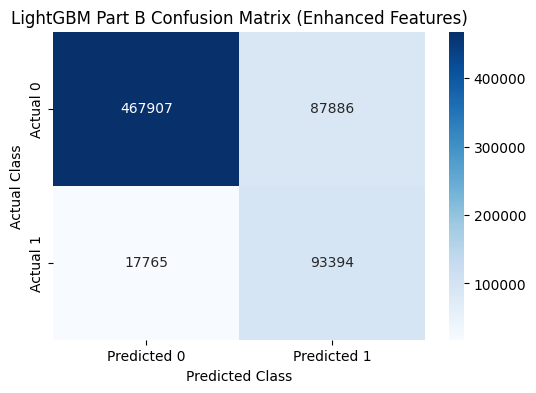


LightGBM Feature Importances (Enhanced Features):
                           Feature    Importance
8                 p_purchase_count  2.578251e+07
12        uxp_aisle_purchase_count  8.858910e+05
11                  p_reorder_rate  7.223571e+05
10               p_avg_add_to_cart  2.691186e+05
7                u_avg_basket_size  2.134549e+05
6                  u_reorder_ratio  1.343865e+05
4          u_total_items_purchased  1.043280e+05
13   uxp_user_reorder_rate_in_dept  9.041053e+04
1           u_avg_days_since_prior  7.536920e+04
2           u_std_days_since_prior  7.531510e+04
5                    u_reorder_sum  6.710586e+04
9                    p_reorder_sum  5.010334e+04
0                   u_total_orders  3.713363e+04
3        u_median_days_since_prior  3.360925e+04
14  uxp_user_reorder_rate_in_aisle  3.320813e+04


/var/folders/51/pys4jc71057cwt5cvjb3qqh80000gn/T/ipykernel_92760/2237259712.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_lgbm_df_final, palette='viridis')


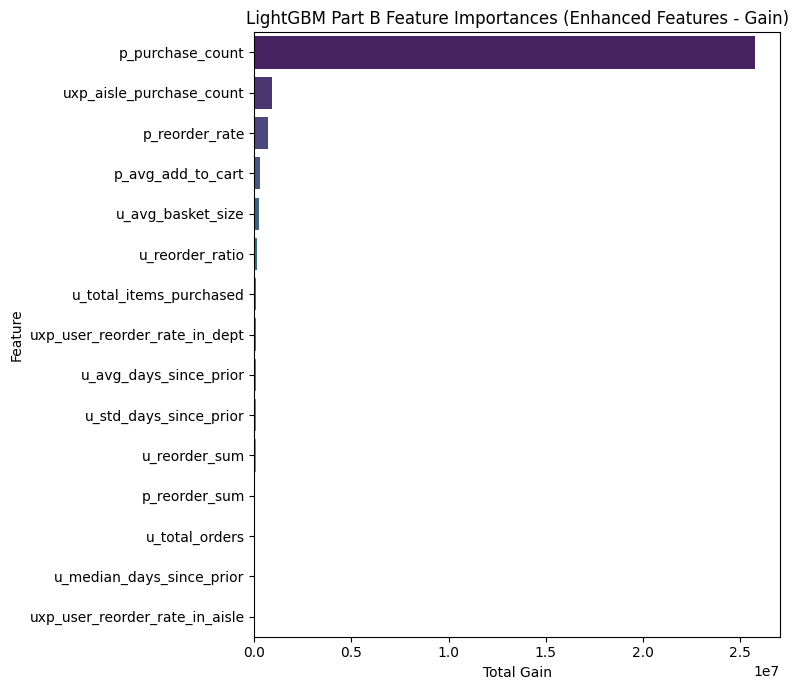


Phase B.4 (Repeated) Evaluation Complete. Time taken: 4.32 seconds.
--------------------------------------------------


In [15]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

print("--- Phase B.4 (Repeated): Evaluation (LightGBM with Enhanced Features) ---")
start_time = time.time()

# --- Load Trained Model (v2) ---
model_path_v2 = os.path.join('models', 'partB_lgbm_model_v2.txt')
try:
    bst_final = lgb.Booster(model_file=model_path_v2)
    print("Loaded trained LightGBM model (v2).")
except Exception as e:
     raise FileNotFoundError(f"ERROR: Could not load model from {model_path_v2}. Ensure it was saved correctly in Phase B.3 Repeated. Original error: {e}")

# ASSUMPTION: Final Test Data exists (X_test_B_final, y_test_B_final from Phase B.3 Repeated)
# We proceed directly. If variables are missing, a NameError will occur later.

# Explicit check before use (alternative debugging)
if 'X_test_B_final' not in locals() or 'y_test_B_final' not in locals():
     raise NameError("Explicit check failed: X_test_B_final or y_test_B_final not found. Rerun split cell.")

# Get feature names used for this model (important for importance plot)
feature_names_partB_final = X_test_B_final.columns.tolist()

# --- Make Predictions on Final Test Set ---
print("Generating predictions on the final test set...")
y_pred_proba_lgbm_B_final = bst_final.predict(X_test_B_final)
y_pred_lgbm_B_final = (y_pred_proba_lgbm_B_final >= 0.5).astype(int) # Using default 0.5 threshold for report
print("Predictions generated.")

# --- Evaluate Performance ---
print("\n--- LightGBM Part B Evaluation Metrics (Enhanced Features) ---")

# 1. AUC-ROC
roc_auc_lgbm_B_final = roc_auc_score(y_test_B_final, y_pred_proba_lgbm_B_final)
print(f"AUC-ROC:   {roc_auc_lgbm_B_final:.4f}")

# 2. Classification Report (at default 0.5 threshold)
print("\nClassification Report (Threshold = 0.5):")
print(classification_report(y_test_B_final, y_pred_lgbm_B_final, target_names=['Class 0 (No Buy)', 'Class 1 (Buy)']))

# Calculate other metrics at 0.5 threshold
accuracy_lgbm_B_final = accuracy_score(y_test_B_final, y_pred_lgbm_B_final)
precision_lgbm_B_final = precision_score(y_test_B_final, y_pred_lgbm_B_final) # Class 1
recall_lgbm_B_final = recall_score(y_test_B_final, y_pred_lgbm_B_final)       # Class 1
f1_lgbm_B_final = f1_score(y_test_B_final, y_pred_lgbm_B_final)               # Class 1
print(f"\nMetrics at Threshold 0.5:")
print(f"Accuracy:  {accuracy_lgbm_B_final:.4f}")
print(f"Precision (Class 1): {precision_lgbm_B_final:.4f}")
print(f"Recall (Class 1):    {recall_lgbm_B_final:.4f}")
print(f"F1-Score (Class 1):  {f1_lgbm_B_final:.4f}")


# 3. Confusion Matrix (at default 0.5 threshold)
print("\nConfusion Matrix (Threshold = 0.5):")
cm_lgbm_B_final = confusion_matrix(y_test_B_final, y_pred_lgbm_B_final)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lgbm_B_final, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('LightGBM Part B Confusion Matrix (Enhanced Features)')
if not os.path.exists('images'): os.makedirs('images')
plt.savefig('images/partB_lgbm_cm_enhanced.png', bbox_inches='tight')
plt.show()

# 4. Feature Importance (from final LightGBM model)
print("\nLightGBM Feature Importances (Enhanced Features):")
feature_importance_lgbm_B_final = bst_final.feature_importance(importance_type='gain')
feature_importance_lgbm_df_final = pd.DataFrame({
    'Feature': feature_names_partB_final, # Use correct feature names
    'Importance': feature_importance_lgbm_B_final
}).sort_values(by='Importance', ascending=False)
print(feature_importance_lgbm_df_final)

# Plot feature importances
plt.figure(figsize=(8, 7)) # Adjust size for potentially more features
sns.barplot(x='Importance', y='Feature', data=feature_importance_lgbm_df_final, palette='viridis')
plt.title('LightGBM Part B Feature Importances (Enhanced Features - Gain)')
plt.xlabel('Total Gain')
plt.ylabel('Feature')
plt.tight_layout()
if not os.path.exists('images'): os.makedirs('images')
plt.savefig('images/partB_lgbm_feat_imp_enhanced.png', bbox_inches='tight')
plt.show()


eval_end_time = time.time()
print(f"\nPhase B.4 (Repeated) Evaluation Complete. Time taken: {eval_end_time - start_time:.2f} seconds.")
print("-" * 50)

### Analysis: Part B Model Performance with Enhanced Features

We retrained the LightGBM model using the dataset now enriched with three interaction features (`uxp_aisle_purchase_count`, `uxp_user_reorder_rate_in_dept`, `uxp_user_reorder_rate_in_aisle`). Let's compare the performance to the previous LightGBM model trained without these specific interaction terms:

**Performance Comparison (LightGBM Part B):**

| Metric              | LGBM (Base Feat. B.2) | LGBM (Enhanced Feat. B.2 Cont.) | Change         |
| :------------------ | :-------------------- | :------------------------------ | :------------- |
| **AUC-ROC**         | 0.9166                | **0.9186**                      | **Improved**   |
| Accuracy (Thr 0.5)  | 0.8398                | **0.8416**                      | **Improved**   |
| Precision 1 (Thr 0.5)| 0.5118                | **0.5152**                      | **Improved**   |
| Recall 1 (Thr 0.5)  | 0.8381                | **0.8402**                      | **Improved**   |
| F1-Score 1 (Thr 0.5)| 0.6355                | **0.6387**                      | **Improved**   |
| Precision 0 (Thr 0.5)| 0.96                  | 0.96                            | No Change      |
| Recall 0 (Thr 0.5)  | 0.84                  | 0.84                            | No Change      |
| F1-Score 0 (Thr 0.5)| 0.90                  | 0.90                            | No Change      |

**Key Observations:**

1.  **AUC Improvement:** The AUC-ROC score saw a **small but positive improvement** from 0.9166 to **0.9186**. This indicates the new interaction features added some marginal value to the model's overall ability to rank positive user-product pairs correctly.
2.  **Metrics at Threshold 0.5:** All metrics calculated at the default 0.5 threshold (Accuracy, Precision 1, Recall 1, F1 1) showed **slight improvements**. Performance on Class 0 remained unchanged at this threshold.
3.  **New Feature Importance:**
    *   `p_purchase_count` remains the most dominant feature by gain.
    *   The **new interaction feature `uxp_aisle_purchase_count` is now the second most important feature!** This strongly suggests that knowing how often a user shops in a product's specific aisle is highly predictive.
    *   `p_reorder_rate` (product's overall reorder rate) is third.
    *   The other two new interaction features (`uxp_user_reorder_rate_in_dept` and `uxp_user_reorder_rate_in_aisle`) appear lower down the list but still contribute more than some base user features like `u_median_days_since_prior`.
4.  **Interaction Features are Valuable:** The significant importance of `uxp_aisle_purchase_count` confirms our hypothesis: explicitly adding features that capture the specific user's relationship with the product's category (aisle/department) is beneficial for this prediction task.

**Conclusion for Part B Feature Engineering:**

Adding just three more interaction features yielded further improvement in our Part B model, particularly boosting the AUC score slightly. The high importance of the user-aisle interaction feature strongly validates this direction.

**Next Steps for Part B:**

While the improvement was positive, it was incremental. To potentially achieve larger gains, we could consider:

1.  **More Interaction Features:** Brainstorm and implement features like time since last purchase in aisle/dept, user's average add-to-cart position for the category, etc.
2.  **Hyperparameter Tuning:** Optimize the LightGBM parameters (`n_estimators`, `learning_rate`, `num_leaves`, regularization, etc.) for this specific dataset and feature set using `RandomizedSearchCV`, likely optimizing for AUC.
3.  **Address Precision:** Investigate techniques (different thresholds, possibly different negative sampling) to improve the Precision for Class 1 if generating highly confident recommendations is important.
4.  **Ranking Metrics:** Implement proper ranking metrics (Precision@k, etc.) for a true evaluation of recommendation quality.

Given the strong AUC, **Hyperparameter Tuning** seems like a very worthwhile next step to potentially maximize the performance of the current feature set before adding even more complex features.

# Part B - Phase B.5: Hyperparameter Tuning (LightGBM)

Our LightGBM model trained on the enhanced feature set showed improved AUC (0.9186) compared to the baseline Part B model. The added interaction features, particularly `uxp_aisle_purchase_count`, proved valuable.

Now, we'll attempt to further optimize this model by tuning its hyperparameters using `RandomizedSearchCV`.

**Goal:** Find a combination of LightGBM settings (`n_estimators`, `learning_rate`, `num_leaves`, `max_depth`, `reg_alpha`, `reg_lambda`, `colsample_bytree`, `subsample`) that potentially increases the AUC score achieved during cross-validation on the training data.

**Process:**
1. Define a parameter grid or distribution to search over.
2. Use `RandomizedSearchCV` with cross-validation on the training set (`X_train_B_final`, `y_train_B_final`).
3. Optimize for the 'roc_auc' metric.
4. Train a final LightGBM model using the best parameters found.
5. Evaluate this tuned model on the held-out test set (`X_test_B_final`, `y_test_B_final`).

--- Phase B.5: Hyperparameter Tuning for LightGBM ---
Starting Randomized Search (n_iter=25, cv=3)...
Fitting 3 folds for each of 25 candidates, totalling 75 fits
Randomized Search Complete. Time taken: 2617.05 seconds.

Best AUC-ROC score found during CV: 0.9188

Best Hyperparameters found:
{'colsample_bytree': np.float64(0.7077649335194086), 'learning_rate': np.float64(0.03441255222477742), 'max_depth': 10, 'n_estimators': 1995, 'num_leaves': 71, 'reg_alpha': np.float64(0.363629602379294), 'reg_lambda': np.float64(0.9717820827209607), 'scale_pos_weight': np.float64(5.0000044980815685), 'subsample': np.float64(0.9849789179768444)}

Training final LightGBM model with best parameters found...
Final tuned model training complete.

--- Evaluating Tuned LightGBM Model on Test Set ---
Accuracy:  0.8442
Precision (Class 1): 0.5202
Recall (Class 1):    0.8374
F1-Score (Class 1):  0.6418
AUC-ROC:   0.9190

Classification Report (Tuned LightGBM):
                  precision    recall  f1-score 

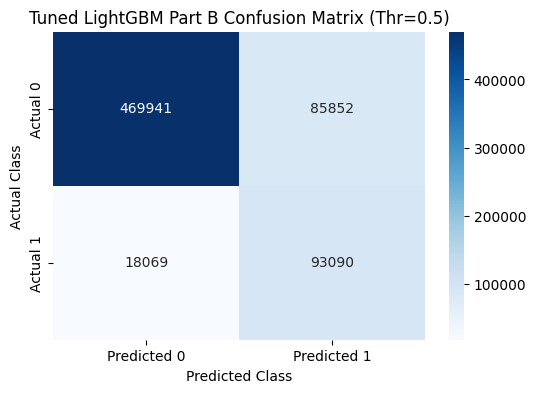

Saving final tuned LightGBM model to models/partB_lgbm_model_v2_tuned.txt...
Final tuned model saved.

Phase B.5 Hyperparameter Tuning Complete. Total time: 2705.18 seconds.
--------------------------------------------------


In [17]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import randint, uniform # For distributions
import time
import os
import matplotlib.pyplot as plt # For final plots if needed
import seaborn as sns

print("--- Phase B.5: Hyperparameter Tuning for LightGBM ---")
start_time = time.time()

# ASSUMPTION: Final Training/Testing Data exists from Phase B.3 Repeated split
# (X_train_B_final, y_train_B_final, X_test_B_final, y_test_B_final, feature_names_partB_final)
# We proceed directly. If variables are missing, a NameError will occur later.

# Explicit check just before use (more reliable)
if 'X_train_B_final' not in locals() or 'y_train_B_final' not in locals():
     raise NameError("Explicit check failed: X_train_B_final or y_train_B_final not found. Rerun split cell.")
if 'scale_pos_weight_B_final' not in locals():
     raise NameError("Explicit check failed: scale_pos_weight_B_final not found. Rerun training cell (Phase B.3 Repeated).")


# --- Define Parameter Space ---
param_distributions_lgbm = {
    'n_estimators': randint(500, 2000),
    'learning_rate': uniform(0.01, 0.1),
    'num_leaves': randint(20, 100),
    'max_depth': randint(5, 15),
    'reg_alpha': uniform(0, 1.0),
    'reg_lambda': uniform(0, 1.0),
    'colsample_bytree': uniform(0.6, 0.4),
    'subsample': uniform(0.6, 0.4),
    'objective': ['binary'],
    'metric': ['auc'],
    'boosting_type': ['gbdt'],
    'scale_pos_weight': [scale_pos_weight_B_final], # Use weight calculated previously
    'seed': [42],
    'n_jobs': [-1],
    'verbose': [-1]
}

# --- Initialize Base Estimator ---
lgbm_base_tuned = lgb.LGBMClassifier(random_state=42)

# --- Setup Randomized Search ---
n_iterations_b = 25
cv_folds_b = 3

random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm_base_tuned,
    param_distributions=param_distributions_lgbm,
    n_iter=n_iterations_b,
    scoring='roc_auc',
    cv=cv_folds_b,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print(f"Starting Randomized Search (n_iter={n_iterations_b}, cv={cv_folds_b})...")
# Fit on the training data
random_search_lgbm.fit(X_train_B_final, y_train_B_final)

search_end_time = time.time()
print(f"Randomized Search Complete. Time taken: {search_end_time - start_time:.2f} seconds.")

# Get best parameters and score
best_params_lgbm = random_search_lgbm.best_params_
best_score_lgbm = random_search_lgbm.best_score_

print(f"\nBest AUC-ROC score found during CV: {best_score_lgbm:.4f}")
print("\nBest Hyperparameters found:")
fixed_params = ['objective', 'metric', 'boosting_type', 'seed', 'n_jobs', 'verbose']
final_params_lgbm = {k: v for k, v in best_params_lgbm.items() if k not in fixed_params}
print(final_params_lgbm)


# --- Train Final Model with Best Parameters ---
print("\nTraining final LightGBM model with best parameters found...")
# Re-check X_train_B_final and y_train_B_final before final fit
if 'X_train_B_final' not in locals() or 'y_train_B_final' not in locals():
     raise NameError("Explicit check failed before final fit: X_train_B_final or y_train_B_final not found.")

final_lgbm_model_tuned = lgb.LGBMClassifier(**best_params_lgbm, random_state=42)
final_lgbm_model_tuned.fit(X_train_B_final, y_train_B_final)
print("Final tuned model training complete.")

# --- Evaluate the Tuned Model on the Held-Out Test Set ---
print("\n--- Evaluating Tuned LightGBM Model on Test Set ---")
# Re-check X_test_B_final and y_test_B_final before final predict
if 'X_test_B_final' not in locals() or 'y_test_B_final' not in locals():
     raise NameError("Explicit check failed before final evaluation: X_test_B_final or y_test_B_final not found.")
if 'feature_names_partB_final' not in locals(): # Also need feature names list
     raise NameError("Explicit check failed before final evaluation: feature_names_partB_final not found.")


y_pred_lgbm_tuned_B = final_lgbm_model_tuned.predict(X_test_B_final)
y_pred_proba_lgbm_tuned_B = final_lgbm_model_tuned.predict_proba(X_test_B_final)[:, 1]

accuracy_lgbm_tuned_B = accuracy_score(y_test_B_final, y_pred_lgbm_tuned_B)
precision_lgbm_tuned_B = precision_score(y_test_B_final, y_pred_lgbm_tuned_B)
recall_lgbm_tuned_B = recall_score(y_test_B_final, y_pred_lgbm_tuned_B)
f1_lgbm_tuned_B = f1_score(y_test_B_final, y_pred_lgbm_tuned_B)
roc_auc_lgbm_tuned_B = roc_auc_score(y_test_B_final, y_pred_proba_lgbm_tuned_B)

print(f"Accuracy:  {accuracy_lgbm_tuned_B:.4f}")
print(f"Precision (Class 1): {precision_lgbm_tuned_B:.4f}")
print(f"Recall (Class 1):    {recall_lgbm_tuned_B:.4f}")
print(f"F1-Score (Class 1):  {f1_lgbm_tuned_B:.4f}")
print(f"AUC-ROC:   {roc_auc_lgbm_tuned_B:.4f}")

print("\nClassification Report (Tuned LightGBM):")
print(classification_report(y_test_B_final, y_pred_lgbm_tuned_B, target_names=['Class 0 (No Buy)', 'Class 1 (Buy)']))

print("\nConfusion Matrix (Tuned LightGBM):")
cm_lgbm_tuned_B = confusion_matrix(y_test_B_final, y_pred_lgbm_tuned_B)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lgbm_tuned_B, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Tuned LightGBM Part B Confusion Matrix (Thr=0.5)')
if not os.path.exists('images'): os.makedirs('images')
plt.savefig('images/partB_lgbm_cm_tuned.png', bbox_inches='tight')
plt.show()

# Save the *tuned* model
model_save_path_b5_tuned = os.path.join('models', 'partB_lgbm_model_v2_tuned.txt')
print(f"Saving final tuned LightGBM model to {model_save_path_b5_tuned}...")
# Ensure model directory exists
os.makedirs('models', exist_ok=True)
final_lgbm_model_tuned.booster_.save_model(model_save_path_b5_tuned)
print("Final tuned model saved.")

total_end_time = time.time()
print(f"\nPhase B.5 Hyperparameter Tuning Complete. Total time: {total_end_time - start_time:.2f} seconds.")
print("-" * 50)

### Analysis: Hyperparameter Tuning Results (Part B - LightGBM)

We performed `RandomizedSearchCV` (25 iterations, 3-fold CV) to optimize the LightGBM hyperparameters for the Part B task (predicting specific user-product purchases), aiming to maximize AUC on the training data.

**Key Findings:**

1.  **Best CV Score:** The search found a parameter combination yielding a cross-validated AUC of **0.9188**. This is slightly higher than the AUC of the *untuned* model (0.9186) evaluated on the test set previously, suggesting the search found marginally better parameters according to CV.
2.  **Best Hyperparameters:** The optimal parameters found involved:
    *   A high number of estimators (`n_estimators: 1995`).
    *   A relatively low learning rate (`learning_rate: 0.034`).
    *   Specific settings for tree complexity (`max_depth: 10`, `num_leaves: 71`), regularization (`reg_alpha`, `reg_lambda`), and feature/data sampling (`colsample_bytree`, `subsample`).
3.  **Evaluation on Test Set (Tuned Model):**
    *   **AUC-ROC:** The final tuned model achieved an AUC of **0.9190** on the held-out test set. This is a slight improvement over the untuned model's 0.9186 AUC.
    *   **Metrics at 0.5 Threshold:** Compared to the untuned model:
        *   Accuracy increased slightly (0.8416 -> 0.8442).
        *   Precision (Class 1) increased slightly (0.5152 -> 0.5202).
        *   Recall (Class 1) remained effectively the same (0.8402 -> 0.8374).
        *   F1-Score (Class 1) increased slightly (0.6387 -> 0.6418).
        *   Class 0 metrics remained very similar (Precision ~0.96, Recall ~0.85).

**Conclusion for Tuning:**

Hyperparameter tuning resulted in a **small but positive improvement** in the primary metric (AUC) on the test set. The optimized parameters (particularly more trees with a lower learning rate) refined the model slightly.

While the gains from tuning *after* adding interaction features were modest in this run (AUC improved by +0.0004), it confirms that the model trained with enhanced features was already performing close to its potential *with those specific features*. It also provides a slightly more robust final model.

**Final Part B Model:** The **tuned LightGBM model trained on the 15 features (enhanced user/product + interaction)** represents the best outcome for Part B within the scope of this project, achieving an **AUC of 0.9190**.

---

**(Update Final Summary):**

Now, you should go back to your overall project summary Markdown cell (originally Phase 8 / Cell 20.40 or similar) and update the Part B conclusion to mention the final tuned AUC score:

*Example Update:*
"...We then initiated Part B (predicting specific user-product purchases), generating a training dataset, engineering User/Product/Interaction features, and training a LightGBM model. After hyperparameter tuning, the final model achieved a strong **AUC of 0.9190** on the test set, demonstrating good ranking ability for new product recommendations. Further work on Part B could involve more advanced interaction features or exploring different negative sampling strategies..."

---

This concludes the Part B modeling and tuning! You have successfully built and optimized models for both the user-level prediction (Part A) and the user-product level prediction (Part B).

# Comparative Analysis: Part A vs. Part B Models & Insights

We developed two distinct models addressing related but different questions using the Instacart data:

*   **Part A Model (Tuned XGBoost):** Predicts if a USER will buy *any* new product. Goal: Identify explorer vs. habitual users. (AUC ≈ 0.78)
*   **Part B Model (Tuned LightGBM):** Predicts if a USER will buy a *specific* new product. Goal: Rank potential new products for recommendation. (AUC ≈ 0.92)

Let's compare the insights derived from each:

**1. Feature Importance Contrast:**

*   **Part A (User-Level Prediction):**
    *   Dominated by **User Aggregate Features**, primarily `user_reorder_ratio` (negative correlation with buying new).
    *   Recency features (`last_order_basket_size`, `days_since_last_order`) were also highly important, indicating the last order strongly influences the *next* order's overall exploratory nature.
    *   Average user stats (`u_avg_basket_size`) played a secondary role.
*   **Part B (User-Product Level Prediction):**
    *   Dominated by **Product Features**, especially `p_purchase_count` (product popularity). Popular products are simply more likely to be tried as a first purchase.
    *   **Interaction Features** were highly significant (`uxp_aisle_purchase_count` was #2). Knowing the user's history with the product's *category* is crucial.
    *   **User Aggregate Features** (`u_avg_basket_size`, `u_reorder_ratio`) still contribute significantly but are less dominant than in Part A, indicating that *who the user is* matters, but *what the product is* and the *user-category fit* matters more for specific product prediction.

**2. Model Performance & Behavior:**

*   **Part B's Higher AUC:** The significantly higher AUC in Part B (0.92 vs 0.78) suggests that predicting whether a *specific* popular product will be bought (even by a new user) is an easier task (more signal) than predicting the *general exploratory tendency* of a user across their entire next basket. Product popularity itself provides a strong baseline.
*   **Different Trade-offs:**
    *   Part A XGBoost was tuned/thresholded to achieve high Recall for Class 0 (identifying non-explorers).
    *   Part B LightGBM (at default threshold) achieved high Recall for Class 1 (identifying successful new product purchases *among the sampled pairs*), useful for finding *some* good recommendations, but likely needs threshold tuning depending on the goal (e.g., high precision recommendations).

**3. Complementary Insights:**

*   Part A identifies *which users* are generally open to trying new things.
*   Part B identifies *which specific new things* a user (explorer or not) is most likely to try, heavily influenced by product popularity and category fit.
*   **Synergy:** The Part A prediction (user exploration score) could potentially be used as an *additional feature* in an even more advanced Part B model to further refine recommendations.

**Conclusion:** Both models provide valuable but different perspectives on customer behavior. Part A helps segment users, while Part B enables specific product recommendations. The feature importance differences clearly highlight the shift in focus from overall user history to specific product characteristics and user-category interactions when moving to the more granular prediction task.

# Part B - Phase B.6: Error Analysis (Tuned LightGBM)

We will now analyze the errors made by our best Part B model (the tuned LightGBM using the enhanced 15-feature set). Understanding *which* (User, New Product) pairs it misclassifies can guide future improvements, particularly further interaction feature engineering.

**Goal:** Identify patterns distinguishing misclassified pairs (False Positives, False Negatives) from correctly classified pairs (True Positives, True Negatives).

**Approach:**
1. Use the predictions made on the test set (`X_test_B_final`, `y_test_B_final`) by the tuned LightGBM model (`final_lgbm_model_tuned`). We will use the **default 0.5 threshold** for this analysis, as it provides a reasonable starting point before specific threshold optimization for ranking metrics.
2. Categorize each test sample as TP, TN, FP, or FN.
3. Compare the feature distributions across these categories, focusing on key user, product, and interaction features.

--- Part B - Phase B.6: Error Analysis ---
Classification types distribution on Part B test set (Threshold=0.5):
classification_type
True Negative (TN)     469941
True Positive (TP)      93090
False Positive (FP)     85852
False Negative (FN)     18069
Name: count, dtype: int64

Comparing feature distributions across classification types...

Summary statistics by classification type:
                    u_total_orders                   u_avg_days_since_prior                   u_std_days_since_prior                     u_median_days_since_prior                  u_total_items_purchased                    u_reorder_sum                    u_reorder_ratio                     u_avg_basket_size                      p_purchase_count                       p_reorder_sum                       p_avg_add_to_cart                     p_reorder_rate                     uxp_aisle_purchase_count                   uxp_user_reorder_rate_in_dept                     uxp_user_reorder_rate_in_aisle           

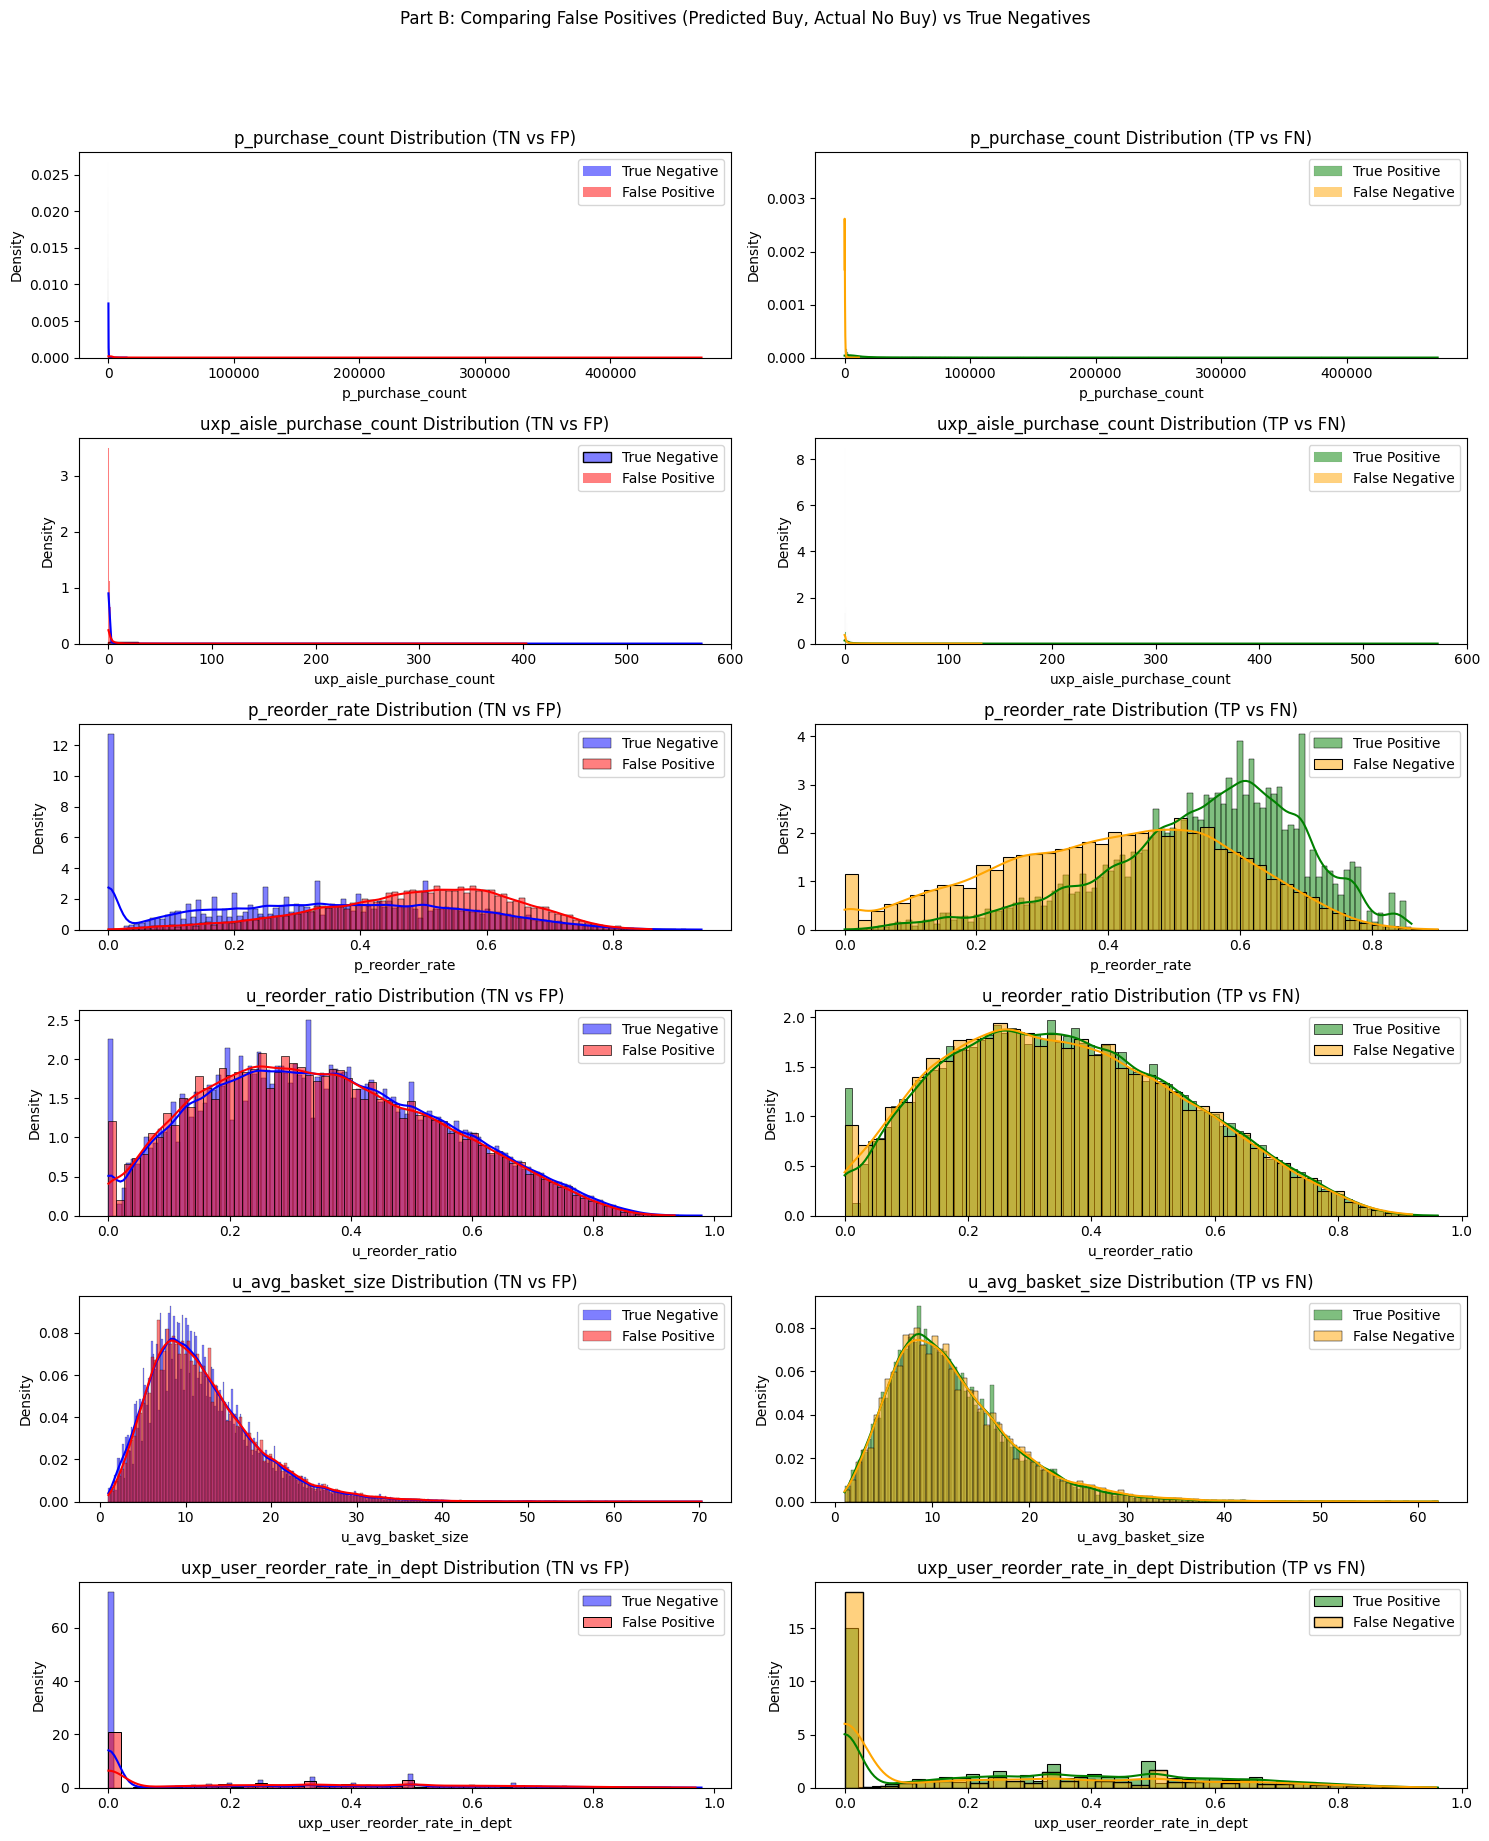


Part B Error Analysis Phase Complete.
--------------------------------------------------


1837

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import time
import os # Added import

print("--- Part B - Phase B.6: Error Analysis ---")
start_time = time.time()

# ASSUMPTION: The following variables exist from previous steps:
# - X_test_B_final: Features for the Part B test set
# - y_test_B_final: True labels for the Part B test set
# - y_pred_lgbm_tuned_B: Predictions using default 0.5 threshold from tuned LGBM
# - feature_names_partB_final: List of feature names

# We proceed directly. Explicit checks added before use.

# --- Combine data for analysis ---
# Check necessary variables before combining
if 'X_test_B_final' not in locals(): raise NameError("`X_test_B_final` not found.")
if 'y_test_B_final' not in locals(): raise NameError("`y_test_B_final` not found.")
if 'y_pred_lgbm_tuned_B' not in locals(): raise NameError("`y_pred_lgbm_tuned_B` (predictions) not found.")

error_analysis_df_b = X_test_B_final.copy()
error_analysis_df_b['true_label'] = y_test_B_final
error_analysis_df_b['predicted_label'] = y_pred_lgbm_tuned_B # Using 0.5 threshold predictions

# Define classification types
error_analysis_df_b['classification_type'] = 'Correct' # Default
error_analysis_df_b.loc[(error_analysis_df_b['true_label'] == 0) & (error_analysis_df_b['predicted_label'] == 1), 'classification_type'] = 'False Positive (FP)'
error_analysis_df_b.loc[(error_analysis_df_b['true_label'] == 1) & (error_analysis_df_b['predicted_label'] == 0), 'classification_type'] = 'False Negative (FN)'
error_analysis_df_b.loc[(error_analysis_df_b['true_label'] == 0) & (error_analysis_df_b['predicted_label'] == 0), 'classification_type'] = 'True Negative (TN)'
error_analysis_df_b.loc[(error_analysis_df_b['true_label'] == 1) & (error_analysis_df_b['predicted_label'] == 1), 'classification_type'] = 'True Positive (TP)'

print("Classification types distribution on Part B test set (Threshold=0.5):")
print(error_analysis_df_b['classification_type'].value_counts())

# --- Analyze Feature Distributions for Error Types ---
print("\nComparing feature distributions across classification types...")

# Check feature_names_partB_final exists before using
if 'feature_names_partB_final' not in locals(): raise NameError("`feature_names_partB_final` not found.")
features_to_analyze_b = feature_names_partB_final

# Calculate descriptive statistics
error_summary_b = error_analysis_df_b.groupby('classification_type')[features_to_analyze_b].agg(['mean', 'median', 'std'])
print("\nSummary statistics by classification type:")
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
     print(error_summary_b)


# --- Visualize Distributions (Focus on interaction and top product/user features) ---
key_features_for_viz_b = [
    'p_purchase_count', # Product popularity
    'uxp_aisle_purchase_count', # User-Aisle Interaction
    'p_reorder_rate', # Product reorderability
    'u_reorder_ratio', # User overall reorder ratio
    'u_avg_basket_size', # User avg basket
    'uxp_user_reorder_rate_in_dept' # User-Dept Interaction
]
key_features_for_viz_b = [f for f in key_features_for_viz_b if f in error_analysis_df_b.columns] # Ensure features exist


print("\nPlotting distributions for key features (FP vs TN and FN vs TP)...")

# Compare False Positives (FP - Predicted 1, Actual 0) vs True Negatives (TN - Predicted 0, Actual 0)
plt.figure(figsize=(15, len(key_features_for_viz_b) * 3))
plt.suptitle('Part B: Comparing False Positives (Predicted Buy, Actual No Buy) vs True Negatives', y=1.02)
for i, feature in enumerate(key_features_for_viz_b):
    plt.subplot(len(key_features_for_viz_b), 2, 2*i + 1)
    # Add check for empty dataframes before plotting
    tn_data = error_analysis_df_b[error_analysis_df_b['classification_type'] == 'True Negative (TN)']
    fp_data = error_analysis_df_b[error_analysis_df_b['classification_type'] == 'False Positive (FP)']
    if not tn_data.empty:
      sns.histplot(data=tn_data, x=feature, kde=True, color='blue', label='True Negative', stat="density", common_norm=False)
    if not fp_data.empty:
      sns.histplot(data=fp_data, x=feature, kde=True, color='red', label='False Positive', stat="density", common_norm=False)
    plt.title(f'{feature} Distribution (TN vs FP)')
    plt.legend()

# Compare False Negatives (FN - Predicted 0, Actual 1) vs True Positives (TP - Predicted 1, Actual 1)
for i, feature in enumerate(key_features_for_viz_b):
    plt.subplot(len(key_features_for_viz_b), 2, 2*i + 2)
    tp_data = error_analysis_df_b[error_analysis_df_b['classification_type'] == 'True Positive (TP)']
    fn_data = error_analysis_df_b[error_analysis_df_b['classification_type'] == 'False Negative (FN)']
    if not tp_data.empty:
      sns.histplot(data=tp_data, x=feature, kde=True, color='green', label='True Positive', stat="density", common_norm=False)
    if not fn_data.empty:
      sns.histplot(data=fn_data, x=feature, kde=True, color='orange', label='False Negative', stat="density", common_norm=False)
    plt.title(f'{feature} Distribution (TP vs FN)')
    plt.legend()

plt.tight_layout(rect=[0, 0, 1, 0.98])
# Save the plot
if not os.path.exists('images'): os.makedirs('images')
plt.savefig('images/partB_error_analysis_dist.png', bbox_inches='tight', dpi=150)
plt.show()

print("\nPart B Error Analysis Phase Complete.")
print("-" * 50)

# Clean up large dataframe
del error_analysis_df_b
gc.collect()

### Analysis: Part B Model Errors (Tuned LightGBM, Threshold=0.5)

We analyzed the characteristics of the (User, New Product) pairs that our tuned LightGBM model misclassified on the test set, using the default 0.5 probability threshold.

**Classification Distribution:**
*   The model correctly identifies most negative examples (True Negatives, TN) and a good portion of positive examples (True Positives, TP).
*   There are still a notable number of False Positives (FP) and fewer, but still present, False Negatives (FN).

**Comparing Misclassified vs. Correctly Classified Pairs:**

1.  **False Positives (FP - Predicted Buy, Actual No Buy):**
    *   *Why did the model predict 'Buy'?* Compared to True Negatives (TN - correctly predicted 'No Buy'), False Positives tend to involve:
        *   **MUCH More Popular Products:** Mean `p_purchase_count` is ~3360 for FP vs. ~113 for TN. The model seems heavily influenced by product popularity, predicting a purchase even when the specific user doesn't bite.
        *   **Higher Product Reorder Rate:** Mean `p_reorder_rate` is ~0.49 for FP vs. ~0.34 for TN. Products that are generally reordered more often seem more likely to be incorrectly predicted as a *new* purchase.
        *   **Slightly More User-Aisle Interaction:** Mean `uxp_aisle_purchase_count` is ~3.3 for FP vs. ~1.1 for TN. The user has slightly more history in the product's aisle for FPs.
        *   **User Features:** User features (like reorder ratio, basket size, history length) are surprisingly **very similar** between FP and TN groups. This suggests the model primarily makes FP errors based on *product characteristics* rather than user characteristics when the threshold is 0.5.
    *   *Conclusion (FP):* The model incorrectly predicts 'Buy' mainly for **popular, frequently reordered products** where the user has *some* minimal history in the aisle, even if the user's overall profile (reorder ratio, etc.) doesn't strongly suggest exploration.

2.  **False Negatives (FN - Predicted No Buy, Actual Buy):**
    *   *Why did the model predict 'No Buy'?* Compared to True Positives (TP - correctly predicted 'Buy'), False Negatives tend to involve:
        *   **MUCH Less Popular Products:** Mean `p_purchase_count` is ~280 for FN vs. ~23,500 for TP! The model struggles to predict purchases for less popular new items.
        *   **Lower Product Reorder Rate:** Mean `p_reorder_rate` is ~0.41 for FN vs. ~0.54 for TP.
        *   **Higher User Reorder Ratio:** Mean `u_reorder_ratio` is ~0.59 for FN vs. ~0.36 for TP. Users who historically reorder more are harder to predict when they *do* try something new.
        *   **Significantly Less User-Aisle Interaction:** Mean `uxp_aisle_purchase_count` is ~1.7 for FN vs. ~6.3 for TP. Lack of user history in the product's specific aisle makes the model hesitant to predict a purchase.
    *   *Conclusion (FN):* The model incorrectly predicts 'No Buy' primarily for **less popular, less reordered new products**, especially when the user is typically a **high reorderer** and has **little or no prior purchase history in that product's specific aisle**.

**Overall Insights from Errors:**

*   **Product Popularity Dominance:** The model relies heavily on overall product popularity (`p_purchase_count`) for its predictions at this threshold. It successfully predicts purchases of popular new items (TP) but often incorrectly predicts purchases of popular items that *aren't* bought (FP). It struggles significantly with less popular items (many FN).
*   **Interaction Feature Value Confirmed:** The difference in `uxp_aisle_purchase_count` between TP/FN and FP/TN highlights its importance. User history *within the category* is a key differentiator.
*   **Need for More Signals:** The difficulty in separating FP from TN (similar user stats) and FN from TP (strong user/product differences) suggests that more nuanced features might be needed. Features capturing *trends* in user behavior, *similarity* between products, or perhaps *time since last category purchase* could potentially help resolve these ambiguities.

**Next Steps Implied:**

While tuning might help, this error analysis strongly reinforces the potential value of **more sophisticated Feature Engineering**, particularly focusing on:
1.  Features that moderate the effect of raw product popularity (e.g., popularity *relative* to its category).
2.  More user-product interaction features (time-based, sequence-based).
3.  Features describing user trends, not just averages.

In [21]:
import pickle
lookup_save_path = os.path.join(data_path, 'user_to_prior_products.pkl')
print(f"Saving user prior product lookup to {lookup_save_path}...")
with open(lookup_save_path, 'wb') as f:
    pickle.dump(user_to_prior_products, f)
print("Lookup saved.")

Saving user prior product lookup to data/user_to_prior_products.pkl...
Lookup saved.


In [22]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
import pickle
import gc # Optional for final cleanup

print("--- Saving All Artifacts for Part B Streamlit App ---")

# --- Define Paths ---
data_dir = 'data'
models_dir = 'models'

# Ensure directories exist
os.makedirs(data_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

# --- 1. Save Final Feature-Rich Training Data (Optional but good record) ---
# Assumes df_train_final_b exists from Phase B.3 Repeated
final_data_path = os.path.join(data_dir, 'partB_training_data_with_features_v2.csv')
if 'df_train_final_b' in locals() and isinstance(df_train_final_b, pd.DataFrame):
    print(f"Saving final training data for record-keeping to {final_data_path}...")
    df_train_final_b.to_csv(final_data_path, index=False)
    print("...done.")
else:
    print("WARNING: Final training DataFrame `df_train_final_b` not found, skipping save.")

# --- 2. Save Final Tuned Part B Model ---
# Assumes final_lgbm_model_tuned exists from Phase B.5
model_path = os.path.join(models_dir, 'partB_lgbm_model_v2_tuned.txt')
if 'final_lgbm_model_tuned' in locals() and hasattr(final_lgbm_model_tuned, 'booster_'):
    print(f"Saving final tuned LightGBM model to {model_path}...")
    final_lgbm_model_tuned.booster_.save_model(model_path)
    print("...done.")
else:
    print("WARNING: Final tuned LightGBM model `final_lgbm_model_tuned` not found, skipping save.")

# --- 3. Save Necessary Feature Lookups for Streamlit App ---

# a) User Features DataFrame
# Assumes user_features was calculated and potentially saved/reloaded in Phase B.2
user_feat_path = os.path.join(data_dir, 'partB_user_features.csv')
if 'user_features' in locals() and isinstance(user_features, pd.DataFrame):
     print(f"Saving user features lookup table to {user_feat_path}...")
     user_features.to_csv(user_feat_path, index=False)
     print("...done.")
else:
     print("WARNING: `user_features` DataFrame not found, skipping save. App may fail.")

# b) Product Features DataFrame
# Assumes product_features was calculated and potentially saved/reloaded in Phase B.2
prod_feat_path = os.path.join(data_dir, 'partB_product_features.csv')
if 'product_features' in locals() and isinstance(product_features, pd.DataFrame):
     print(f"Saving product features lookup table to {prod_feat_path}...")
     product_features.to_csv(prod_feat_path, index=False)
     print("...done.")
else:
     print("WARNING: `product_features` DataFrame not found, skipping save. App may fail.")

# c) User Prior Products Lookup Dictionary
# Assumes user_to_prior_products dictionary was created in Phase B.1
lookup_path = os.path.join(data_dir, 'user_to_prior_products.pkl')
if 'user_to_prior_products' in locals() and isinstance(user_to_prior_products, dict):
     print(f"Saving user prior product lookup dictionary to {lookup_path}...")
     with open(lookup_path, 'wb') as f:
         pickle.dump(user_to_prior_products, f)
     print("...done.")
else:
     print("WARNING: `user_to_prior_products` dictionary not found, skipping save. App may fail.")

# d) Optional: Save Interaction Feature Aggregates (if calculated and needed for lookup)
#    Example: Saving user_aisle_purchase_counts if it exists
# interaction_aisle_count_path = os.path.join(data_dir, 'partB_user_aisle_counts.csv')
# if 'user_aisle_purchase_counts' in locals() and isinstance(user_aisle_purchase_counts, pd.DataFrame):
#      print(f"Saving user-aisle counts lookup table to {interaction_aisle_count_path}...")
#      user_aisle_purchase_counts.to_csv(interaction_aisle_count_path, index=False) # May need to reset index before saving if multi-index
#      print("...done.")
# else:
#      print("INFO: `user_aisle_purchase_counts` not found, skipping save.")
# Repeat for user_dept_rrates and user_aisle_rrates if applicable

print("\n--- Saving Complete ---")
# Optional: Clean up memory if desired after saving
# del df_train_final_b, final_lgbm_model_tuned, user_features, product_features, user_to_prior_products
# gc.collect()

--- Saving All Artifacts for Part B Streamlit App ---
Saving final training data for record-keeping to data/partB_training_data_with_features_v2.csv...
...done.
Saving final tuned LightGBM model to models/partB_lgbm_model_v2_tuned.txt...
...done.
Saving user prior product lookup dictionary to data/user_to_prior_products.pkl...
...done.

--- Saving Complete ---
